# SNVs: Illumina vs ONT

**Author**: Katarina Braun 

## Overview

This script cleans the VCF files generated by the `Illumina Sniffles`  and the `ONT SISPA` pipeline and generates "SNV correlation plots" to compare ONT and Illumina SNVs. 

## Dependencies 
- pandas
- numpy
- matplotlib
- glob
- os
- functools
- pandas
- itertools
- glob
- os
- sklearn 
 
**Visualize**: 
One scatterplot per gene where: 
- x Illumina SNV FREQ 
- y ONT SNV FREQ 
- datapoints are plotted as closed if nonsynonymous and open if synonymous

### a note about numbering schemes 

Everything was mapped to the Madison, WI case reference sequence: MT039887

The numbering schemes in input VCFs differs between the Illumina and ONT files. 
1. **Illumina**: starts from 1 at the beginning of each ORF. 
2. **ONT**: starts from 1 at the beginning of the reference file and increases sequentially through the entire genome. Some of the code below will adjust the numbering scheme in the ONT files to match the Illumina files -- but just make sure you are aware of this if you are looking at the upstream VCF files. 

## Input: 

1. SNV files in VCF format (output from `Sniffles`):
    - `Illumina-Sniffles VCFs`
    
2. SNV files in VCF format (output from the ONT pipeline):
    - `ONT-SISPA VCFs` 

## Output: 

1. Cleaned generated from VCF input files.     

2. Spliced data by sample ID, gene, and synonymous vs nonsynonymous.

3. A PDF version of SNV figures. 


### import modules and dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import glob
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pathlib import Path
from os.path import splitext
from functools import reduce
from pandas.api.types import is_numeric_dtype
import warnings
from pandas.core.common import SettingWithCopyWarning
from matplotlib.font_manager import FontProperties 
from matplotlib import cm
import itertools
from matplotlib import container
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.patches as mpatches

## data cleaning

### define functions for data cleaning

In [2]:
# get a list of filenames without the extension from some directory 
# example usage: `get_files('../data_derived/SNV', 'VCFlist')`
def get_files(path): 
    filelist = [os.path.splitext(filename)[0] for filename in os.listdir(path)]
    filelist.remove('.DS_Store')
    return(filelist)
#     print(filelist)

# load all text files in a directory into Pandas dataframes 
# path should be set to path to the text files that you would like to load into dataframes 
# set this function equal to some variable which will then be callable as a list of the dataframes 
# call each dataframe then calling items of the list, the specific sample name can be found within the VCF or dataframe
def load_dataframes(path):
    filelist = [os.path.splitext(file)[0] for file in os.listdir(path) if file.endswith('.vcf')]
    list_of_DFs = []
    for file in filelist: 
        DF = path + '/' + file + '.vcf'
        file = pd.read_csv(DF, header=0, sep='\t', low_memory=False)
        list_of_DFs.append(file)
    print(filelist)
    return(list_of_DFs)

# manipulate SNV dataframes 
# first run load_dataframes and generate a variable for the list of DFs, then feed that variable 
# into this function to clean the dataframe up and save to new CSV 
def clean_dataframes(path, list_of_DFs):
    if not os.path.exists(path + '/cleaned'):
            os.makedirs(path + '/cleaned')
    for DF in list_of_DFs:
        # save the specific animal ID and timepoint to a temporary name = sample 
        sample = DF.columns[9]
        # drop columns that are not needed
        DF.drop(['#CHROM', 'ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT'], axis=1)
        # replace . with "syn" (synonymous SNV) for clarity
        DF['AAchange'] = DF['AAchange'].replace({'.':'syn'})
#         DF['gene'] = DF['gene'].replace({'NA gene':'NA'})
        # create new column with GENE_REF-POS-ALT = SNP
        DF['SNP'] = DF['gene'] + '_' + DF['REF'] + DF['POS'].map(str) + DF['ALT'] + '_' + DF['AAchange']
        # delete rows in the dataframe that contain "not in ORF" -- I don't need to track these SNPs
        DF = DF[~DF['AAchange'].astype(str).str.contains('not in ORF')]
        # reorder the columns to make a little more sense
        DF = DF[['gene', 'POS', 'REF', 'ALT', 'FREQ', 'SNP']]
        # add a column to convert FREQ to % of the population 
        DF['% of population'] = DF['FREQ'].multiply(100)
        # make a cleaned directory if it does not already exist 
        if sample.endswith('_rep2'):
            sample_mod = sample[:-5]
            DF.to_csv(path + '/cleaned/' + sample_mod + '-cleaned.csv', sep='\t')
        else:
            DF.to_csv(path + '/cleaned/' + sample + '-cleaned.csv', sep='\t')
            
# manipulate SNV dataframes -- this function is specifically for the ONT VCFS, which are formatted a bit differently than the Illumina VCFs
# first run load_dataframes and generate a variable for the list of DFs, then feed that variable 
# into this function to clean the dataframe up and save to new CSV 
def clean_ONTdataframes(path, list_of_DFs):
    if not os.path.exists(path + '/cleaned'):
            os.makedirs(path + '/cleaned')
    AA_dict = {"Ala": "A", "Arg":"R", "Asn":"N", "Asp":"D", "Asx":"B", "Cys":"C", "Glu":"E", "Gln":"Q", "Glx":"Z", "Gly":"G", "His":"H", "Ile":"I", "Leu":"L", "Lys":"K", "Met":"M", "Phe":"F", "Pro":"P", "Ser":"S", "Thr":"T", "Trp":"W", "Tyr":"Y", "Val":"V"}
    gene_dict = {"orf1a":"ORF1a", "orf1b":"ORF1b", "s":"S", "orf3a":"ORF3a", "e":"E", "m":"M", "orf6":"ORF6", "orf7a":"ORF7a", "orf8":"ORF8", "n":"N", "orf10":"ORF10"}
    for DF in list_of_DFs:
        sample = DF.columns[10]
        # drop columns that are not needed
        DF = DF.drop(['#CHROM', 'ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT'], axis=1)
        DF[' Gene_ID '].replace('gene-','',regex=True,inplace=True)
        DF[' HGVS.p '].replace('p.','',regex=True,inplace=True)
        DF[' Annotation '].replace('_variant','',regex=True,inplace=True)
        DF[' Annotation '].replace('missence','nonsynonymous',regex=True,inplace=True)
        DF = DF.rename(columns={' Gene_ID ': 'gene', 'AF': 'FREQ'})
        DF['% of population'] = DF['FREQ'].multiply(100)
        DF['gene'] = DF['gene'].replace(gene_dict, regex=True)
        DF['SNP'] = DF['gene'] + '_' + DF['REF'] + DF['POS'].map(str) + DF['ALT'] + '_' + DF[' HGVS.p ']
#         DF['SNP'] = DF['SNP'].replace(AA_dict, regex=True)
        DF = DF[['gene', 'POS', 'REF', 'ALT', 'FREQ', 'SNP', '% of population']]
        # make a cleaned directory if it does not already exist 
        DF.to_csv(path + '/cleaned/' + sample + '-cleaned.csv', sep='\t')

### VCF file data-cleaning

In [3]:
# generate a list of dataframes, loaded from Illumina VCF files 
list_of_Illumina_DFs = load_dataframes('VCFs_Illumina/')

['p1_veroE6', 'p1_veroSTAT1KO', 'p2a_vero76', 'primary_NP_swab', 'p1_vero76', 'p2b_vero76']


In [4]:
# clean up all of the dataframes and save to new CSV files 
clean_dataframes('VCFs_Illumina/', list_of_Illumina_DFs)

In [5]:
# generate a list of dataframes, loaded from ONT VCF files 
list_of_ONT_DFs = load_dataframes('VCFs_ONT/')

['p1_veroE6', 'p1_veroSTAT1KO', 'p2a_vero76', 'primary_NP_swab', 'p1_vero76', 'p2b_vero76']


In [6]:
clean_ONTdataframes('VCFs_ONT/', list_of_ONT_DFs)

In [7]:
# load cleaned Illumina dataframes 
p1_vero76_Illumina = pd.read_csv('VCFs_Illumina/cleaned/p1_vero76-cleaned.csv', sep='\t')
p1_veroE6_Illumina = pd.read_csv('VCFs_Illumina/cleaned/p1_veroE6-cleaned.csv', sep='\t')
p1_veroSTAT1KO_Illumina = pd.read_csv('VCFs_Illumina/cleaned/p1_veroSTAT1KO-cleaned.csv', sep='\t')
p2a_vero76_Illumina = pd.read_csv('VCFs_Illumina/cleaned/p2a_vero76-cleaned.csv', sep='\t')
p2b_vero76_Illumina = pd.read_csv('VCFs_Illumina/cleaned/p2b_vero76-cleaned.csv', sep='\t')
primary_NP_swab_Illumina = pd.read_csv('VCFs_Illumina/cleaned/primary_NP_swab-cleaned.csv', sep='\t')

# load cleaned ONT dataframes 
p1_vero76_ONT = pd.read_csv('VCFs_ONT/cleaned/p1_vero76-cleaned.csv', sep='\t')
p1_veroE6_ONT = pd.read_csv('VCFs_ONT/cleaned/p1_veroE6-cleaned.csv', sep='\t')
p1_veroSTAT1KO_ONT = pd.read_csv('VCFs_ONT/cleaned/p1_veroSTAT1KO-cleaned.csv', sep='\t')
p2a_vero76_ONT = pd.read_csv('VCFs_ONT/cleaned/p2a_vero76-cleaned.csv', sep='\t')
p2b_vero76_ONT = pd.read_csv('VCFs_ONT/cleaned/p2b_vero76-cleaned.csv', sep='\t')
primary_NP_swab_ONT = pd.read_csv('VCFs_ONT/cleaned/primary_NP_swab-cleaned.csv', sep='\t')

##

## slice dataframes into genes and synonymous vs nonsynonymous SNPs

### define functions to slice dataframes into genes syn vs nonsyn SNPs

In [8]:
# slice merged ferret dataframe into individual genes and synonymous and nonsynonymous variants 

DF_slices = ['ORF1a_syn', 'ORF1a_nonsyn', 'ORF1b_syn', 'ORF1b_nonsyn', 'S_syn', 'S_nonsyn', 'ORF3a_syn', 'ORF3a_nonsyn', 'E_syn', 'E_nonsyn', 'M_syn', 'M_nonsyn', 'ORF6_syn', 'ORF6_nonsyn', 'ORF7a_syn', 'ORF7a_nonsyn', 'ORF8_syn', 'ORF8_nonsyn', 'N_syn', 'N_nonsyn', 'ORF10_syn', 'ORF10_nonsyn']
genes = ['ORF1a_', 'ORF1b_', 'S_', 'ORF3a_', 'E_', 'M_', 'ORF6_', 'ORF7a_', 'ORF8_', 'N_', 'ORF10_']
strings = [6, 6, 2, 6, 2, 2, 6, 6, 6, 2, 7]

# genes, strings and path are defined above, this shouldn't be changed
def slice_dataframes(sample, samplenum, DF_slices, genes, strings, path):
    if not os.path.exists(path + '/by_gene_segment/' + samplenum):
            os.makedirs(path + '/by_gene_segment/' + samplenum)
    DF = sample
    for DF_slice in DF_slices: 
        DF_slice = pd.DataFrame()
    DF_by_gene = []
    for (gene, string) in zip(genes, strings):
        gene = DF.loc[DF['SNP'].str.contains(gene)]
        if gene.empty:
            pass
        else: 
            gene['SNP'] = gene['SNP'].map(lambda x : str(x)[string:])
            gene['POS'] = gene['SNP'].str.extract('(\d+)')
            gene['POS'] = pd.to_numeric(gene['POS'])
            gene = gene.sort_values(by=['POS'])
            gene = gene.drop(['POS'], axis=1)
        DF_by_gene.append(gene)
#     return(DF_by_gene)
    DF_slices = []
    for (DF, gene) in zip(DF_by_gene, genes): 
        if DF.empty is False:
            DF_syn = DF.loc[DF['SNP'].str.contains("syn")]
            DF_syn['SNP'] = gene + DF_syn['SNP'].astype(str)
            DF_nonsyn = DF.loc[~DF['SNP'].str.contains("syn")]
            DF_nonsyn['SNP'] = gene + DF_nonsyn['SNP'].astype(str)
            # save these dataframes to CSV files
            if DF_syn.empty is False: 
                DF_syn.to_csv(path + '/by_gene_segment/' + samplenum + '/' + gene + '_syn.csv', sep='\t')
            if DF_nonsyn.empty is False:  
                DF_nonsyn.to_csv(path + '/by_gene_segment/' + samplenum + '/' + gene + '_nonsyn.csv', sep='\t')
        else: 
            pass
            
##

In [9]:
# ignore some errors that will pop up 
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

DF_slices = ['ORF1a_syn', 'ORF1a_nonsyn', 'ORF1b_syn', 'ORF1b_nonsyn', 'S_syn', 'S_nonsyn', 'ORF3a_syn', 'ORF3a_nonsyn', 'E_syn', 'E_nonsyn', 'M_syn', 'M_nonsyn', 'ORF6_syn', 'ORF6_nonsyn', 'ORF7a_syn', 'ORF7a_nonsyn', 'ORF8_syn', 'ORF8_nonsyn', 'N_syn', 'N_nonsyn', 'ORF10_syn', 'ORF10_nonsyn']
genes = ['ORF1a_', 'ORF1b_', 'S_', 'ORF3a_', 'E_', 'M_', 'ORF6_', 'ORF7a_', 'ORF8_', 'N_', 'ORF10_']
strings = [6, 6, 2, 6, 2, 2, 6, 6, 6, 2, 7]

# slice all Illumina merged dataframes into gene segments as well as synonymous and nonsynonymoust variants 
p1_vero76_Illumina_slices = slice_dataframes(p1_vero76_Illumina, 'p1_vero76_Illumina', DF_slices, genes, strings, 'VCFs_Illumina/')
p1_veroE6_Illumina_slices = slice_dataframes(p1_veroE6_Illumina, 'p1_veroE6_Illumina', DF_slices, genes, strings, 'VCFs_Illumina/')
p1_veroSTAT1KO_Illumina_slices = slice_dataframes(p1_veroSTAT1KO_Illumina, 'p1_veroSTAT1KO_Illumina', DF_slices, genes, strings, 'VCFs_Illumina/')
p2a_vero76_Illumina_slices = slice_dataframes(p2a_vero76_Illumina, 'p2a_vero76_Illumina', DF_slices, genes, strings, 'VCFs_Illumina/')
p2b_vero76_Illumina_slices = slice_dataframes(p2b_vero76_Illumina, 'p2b_vero76_Illumina', DF_slices, genes, strings, 'VCFs_Illumina/')
primary_NP_swab_Illumina_slices = slice_dataframes(primary_NP_swab_Illumina, 'primary_NP_swab_Illumina', DF_slices, genes, strings, 'VCFs_Illumina/')

# slice all ONT merged dataframes into gene segments as well as synonymous and nonsynonymoust variants 
p1_vero76_ONT_slices = slice_dataframes(p1_vero76_ONT, 'p1_vero76_ONT', DF_slices, genes, strings, 'VCFs_ONT/')
p1_veroE6_ONT_slices = slice_dataframes(p1_veroE6_ONT, 'p1_veroE6_ONT', DF_slices, genes, strings, 'VCFs_ONT/')
p1_veroSTAT1KO_ONT_slices = slice_dataframes(p1_veroSTAT1KO_ONT, 'p1_veroSTAT1KO_ONT', DF_slices, genes, strings, 'VCFs_ONT/')
p2a_vero76_ONT_slices = slice_dataframes(p2a_vero76_ONT, 'p2a_vero76_ONT', DF_slices, genes, strings, 'VCFs_ONT/')
p2b_vero76_ONT_slices = slice_dataframes(p2b_vero76_ONT, 'p2b_vero76_ONT', DF_slices, genes, strings, 'VCFs_ONT/')
primary_NP_swab_ONT_slices = slice_dataframes(primary_NP_swab_ONT, 'primary_NP_swab_ONT', DF_slices, genes, strings, 'VCFs_ONT/')

###

### load individual genes into dataframes (p1_vero76_Illumina)

In [10]:
p1_vero76_Illumina_ORF1a_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_vero76_Illumina/ORF1a__syn.csv', header=0, sep='\t', low_memory=False)
p1_vero76_Illumina_ORF1a_syn['loc'] = p1_vero76_Illumina_ORF1a_syn['SNP'].str.split('_').str[1]
p1_vero76_Illumina_ORF1a_syn['loc'] = p1_vero76_Illumina_ORF1a_syn['loc'].str.extract('(\d+)').astype(int)
p1_vero76_Illumina_ORF1a_syn = p1_vero76_Illumina_ORF1a_syn.sort_values('loc')

p1_vero76_Illumina_ORF1a_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_vero76_Illumina/ORF1a__nonsyn.csv', header=0, sep='\t', low_memory=False)
p1_vero76_Illumina_ORF1a_nonsyn['loc'] = p1_vero76_Illumina_ORF1a_nonsyn['SNP'].str.split('_').str[1]
p1_vero76_Illumina_ORF1a_nonsyn['loc'] = p1_vero76_Illumina_ORF1a_nonsyn['loc'].str.extract('(\d+)').astype(int)
p1_vero76_Illumina_ORF1a_nonsyn = p1_vero76_Illumina_ORF1a_nonsyn.sort_values('loc')

p1_vero76_Illumina_ORF1b_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_vero76_Illumina/ORF1b__syn.csv', header=0, sep='\t', low_memory=False)
p1_vero76_Illumina_ORF1b_syn['loc'] = p1_vero76_Illumina_ORF1b_syn['SNP'].str.split('_').str[1]
p1_vero76_Illumina_ORF1b_syn['loc'] = p1_vero76_Illumina_ORF1b_syn['loc'].str.extract('(\d+)').astype(int)
p1_vero76_Illumina_ORF1b_syn = p1_vero76_Illumina_ORF1b_syn.sort_values('loc')

p1_vero76_Illumina_ORF1b_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_vero76_Illumina/ORF1b__nonsyn.csv', header=0, sep='\t', low_memory=False)
p1_vero76_Illumina_ORF1b_nonsyn['loc'] = p1_vero76_Illumina_ORF1b_nonsyn['SNP'].str.split('_').str[1]
p1_vero76_Illumina_ORF1b_nonsyn['loc'] = p1_vero76_Illumina_ORF1b_nonsyn['loc'].str.extract('(\d+)').astype(int)
p1_vero76_Illumina_ORF1b_nonsyn = p1_vero76_Illumina_ORF1b_nonsyn.sort_values('loc')

p1_vero76_Illumina_S_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_vero76_Illumina/S__syn.csv', header=0, sep='\t', low_memory=False)
p1_vero76_Illumina_S_syn['loc'] = p1_vero76_Illumina_S_syn['SNP'].str.split('_').str[1]
p1_vero76_Illumina_S_syn['loc'] = p1_vero76_Illumina_S_syn['loc'].str.extract('(\d+)').astype(int)
p1_vero76_Illumina_S_syn = p1_vero76_Illumina_S_syn.sort_values('loc')

p1_vero76_Illumina_S_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_vero76_Illumina/S__nonsyn.csv', header=0, sep='\t', low_memory=False)
p1_vero76_Illumina_S_nonsyn['loc'] = p1_vero76_Illumina_S_nonsyn['SNP'].str.split('_').str[1]
p1_vero76_Illumina_S_nonsyn['loc'] = p1_vero76_Illumina_S_nonsyn['loc'].str.extract('(\d+)').astype(int)
p1_vero76_Illumina_S_nonsyn = p1_vero76_Illumina_S_nonsyn.sort_values('loc')

p1_vero76_Illumina_ORF3a_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_vero76_Illumina/ORF3a__nonsyn.csv', header=0, sep='\t', low_memory=False)
p1_vero76_Illumina_ORF3a_nonsyn['loc'] = p1_vero76_Illumina_ORF3a_nonsyn['SNP'].str.split('_').str[1]
p1_vero76_Illumina_ORF3a_nonsyn['loc'] = p1_vero76_Illumina_ORF3a_nonsyn['loc'].str.extract('(\d+)').astype(int)
p1_vero76_Illumina_ORF3a_nonsyn = p1_vero76_Illumina_ORF3a_nonsyn.sort_values('loc')

p1_vero76_Illumina_ORF7a_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_vero76_Illumina/ORF7a__syn.csv', header=0, sep='\t', low_memory=False)
p1_vero76_Illumina_ORF7a_syn['loc'] = p1_vero76_Illumina_ORF7a_syn['SNP'].str.split('_').str[1]
p1_vero76_Illumina_ORF7a_syn['loc'] = p1_vero76_Illumina_ORF7a_syn['loc'].str.extract('(\d+)').astype(int)
p1_vero76_Illumina_ORF7a_syn = p1_vero76_Illumina_ORF7a_syn.sort_values('loc')

p1_vero76_Illumina_ORF7a_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_vero76_Illumina/ORF7a__nonsyn.csv', header=0, sep='\t', low_memory=False)
p1_vero76_Illumina_ORF7a_nonsyn['loc'] = p1_vero76_Illumina_ORF7a_nonsyn['SNP'].str.split('_').str[1]
p1_vero76_Illumina_ORF7a_nonsyn['loc'] = p1_vero76_Illumina_ORF7a_nonsyn['loc'].str.extract('(\d+)').astype(int)
p1_vero76_Illumina_ORF7a_nonsyn = p1_vero76_Illumina_ORF7a_nonsyn.sort_values('loc')

p1_vero76_Illumina_ORF10_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_vero76_Illumina/ORF10__nonsyn.csv', header=0, sep='\t', low_memory=False)
p1_vero76_Illumina_ORF10_nonsyn['loc'] = p1_vero76_Illumina_ORF10_nonsyn['SNP'].str.split('_').str[1]
p1_vero76_Illumina_ORF10_nonsyn['loc'] = p1_vero76_Illumina_ORF10_nonsyn['loc'].str.extract('(\d+)').astype(int)
p1_vero76_Illumina_ORF10_nonsyn = p1_vero76_Illumina_ORF10_nonsyn.sort_values('loc')


##

### load individual genes into dataframes (p1_vero76_ONT)

In [11]:
p1_vero76_ONT_ORF1a_syn = pd.read_csv('VCFs_ONT/by_gene_segment/p1_vero76_ONT/ORF1a__syn.csv', header=0, sep='\t', low_memory=False)
p1_vero76_ONT_ORF1a_syn['loc'] = p1_vero76_ONT_ORF1a_syn['SNP'].str.split('_').str[1]
p1_vero76_ONT_ORF1a_syn['loc'] = p1_vero76_ONT_ORF1a_syn['loc'].str.extract('(\d+)').astype(int)
p1_vero76_ONT_ORF1a_syn = p1_vero76_ONT_ORF1a_syn.sort_values('loc')
p1_vero76_ONT_ORF1a_syn['loc'] = p1_vero76_ONT_ORF1a_syn['loc'] - 265


### load individual genes into dataframes (p1_veroE6_Illumina)

In [12]:
p1_veroE6_Illumina_ORF1a_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_veroE6_Illumina/ORF1a__syn.csv', header=0, sep='\t', low_memory=False)
p1_veroE6_Illumina_ORF1a_syn['loc'] = p1_veroE6_Illumina_ORF1a_syn['SNP'].str.split('_').str[1]
p1_veroE6_Illumina_ORF1a_syn['loc'] = p1_veroE6_Illumina_ORF1a_syn['loc'].str.extract('(\d+)').astype(int)
p1_veroE6_Illumina_ORF1a_syn = p1_veroE6_Illumina_ORF1a_syn.sort_values('loc')

p1_veroE6_Illumina_ORF1a_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_veroE6_Illumina/ORF1a__nonsyn.csv', header=0, sep='\t', low_memory=False)
p1_veroE6_Illumina_ORF1a_nonsyn['loc'] = p1_veroE6_Illumina_ORF1a_nonsyn['SNP'].str.split('_').str[1]
p1_veroE6_Illumina_ORF1a_nonsyn['loc'] = p1_veroE6_Illumina_ORF1a_nonsyn['loc'].str.extract('(\d+)').astype(int)
p1_veroE6_Illumina_ORF1a_nonsyn = p1_veroE6_Illumina_ORF1a_nonsyn.sort_values('loc')

p1_veroE6_Illumina_ORF1b_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_veroE6_Illumina/ORF1b__nonsyn.csv', header=0, sep='\t', low_memory=False)
p1_veroE6_Illumina_ORF1b_nonsyn['loc'] = p1_veroE6_Illumina_ORF1b_nonsyn['SNP'].str.split('_').str[1]
p1_veroE6_Illumina_ORF1b_nonsyn['loc'] = p1_veroE6_Illumina_ORF1b_nonsyn['loc'].str.extract('(\d+)').astype(int)
p1_veroE6_Illumina_ORF1b_nonsyn = p1_veroE6_Illumina_ORF1b_nonsyn.sort_values('loc')

p1_veroE6_Illumina_S_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_veroE6_Illumina/S__nonsyn.csv', header=0, sep='\t', low_memory=False)
p1_veroE6_Illumina_S_nonsyn['loc'] = p1_veroE6_Illumina_S_nonsyn['SNP'].str.split('_').str[1]
p1_veroE6_Illumina_S_nonsyn['loc'] = p1_veroE6_Illumina_S_nonsyn['loc'].str.extract('(\d+)').astype(int)
p1_veroE6_Illumina_S_nonsyn = p1_veroE6_Illumina_S_nonsyn.sort_values('loc')

p1_veroE6_Illumina_E_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_veroE6_Illumina/E__nonsyn.csv', header=0, sep='\t', low_memory=False)
p1_veroE6_Illumina_E_nonsyn['loc'] = p1_veroE6_Illumina_E_nonsyn['SNP'].str.split('_').str[1]
p1_veroE6_Illumina_E_nonsyn['loc'] = p1_veroE6_Illumina_E_nonsyn['loc'].str.extract('(\d+)').astype(int)
p1_veroE6_Illumina_E_nonsyn = p1_veroE6_Illumina_E_nonsyn.sort_values('loc')

p1_veroE6_Illumina_ORF3a_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_veroE6_Illumina/ORF3a__syn.csv', header=0, sep='\t', low_memory=False)
p1_veroE6_Illumina_ORF3a_syn['loc'] = p1_veroE6_Illumina_ORF3a_syn['SNP'].str.split('_').str[1]
p1_veroE6_Illumina_ORF3a_syn['loc'] = p1_veroE6_Illumina_ORF3a_syn['loc'].str.extract('(\d+)').astype(int)
p1_veroE6_Illumina_ORF3a_syn = p1_veroE6_Illumina_ORF3a_syn.sort_values('loc')

p1_veroE6_Illumina_ORF7a_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_veroE6_Illumina/ORF7a__syn.csv', header=0, sep='\t', low_memory=False)
p1_veroE6_Illumina_ORF7a_syn['loc'] = p1_veroE6_Illumina_ORF7a_syn['SNP'].str.split('_').str[1]
p1_veroE6_Illumina_ORF7a_syn['loc'] = p1_veroE6_Illumina_ORF7a_syn['loc'].str.extract('(\d+)').astype(int)
p1_veroE6_Illumina_ORF7a_syn = p1_veroE6_Illumina_ORF7a_syn.sort_values('loc')

p1_veroE6_Illumina_ORF7a_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_veroE6_Illumina/ORF7a__nonsyn.csv', header=0, sep='\t', low_memory=False)
p1_veroE6_Illumina_ORF7a_nonsyn['loc'] = p1_veroE6_Illumina_ORF7a_nonsyn['SNP'].str.split('_').str[1]
p1_veroE6_Illumina_ORF7a_nonsyn['loc'] = p1_veroE6_Illumina_ORF7a_nonsyn['loc'].str.extract('(\d+)').astype(int)
p1_veroE6_Illumina_ORF7a_nonsyn = p1_veroE6_Illumina_ORF7a_nonsyn.sort_values('loc')


##

### load individual genes into dataframes (p1_veroE6_ONT)

In [13]:
p1_veroE6_ONT_ORF1a_syn = pd.read_csv('VCFs_ONT/by_gene_segment/p1_veroE6_ONT/ORF1a__syn.csv', header=0, sep='\t', low_memory=False)
p1_veroE6_ONT_ORF1a_syn['loc'] = p1_veroE6_ONT_ORF1a_syn['SNP'].str.split('_').str[1]
p1_veroE6_ONT_ORF1a_syn['loc'] = p1_veroE6_ONT_ORF1a_syn['loc'].str.extract('(\d+)').astype(int)
p1_veroE6_ONT_ORF1a_syn = p1_veroE6_ONT_ORF1a_syn.sort_values('loc')
p1_veroE6_ONT_ORF1a_syn['loc'] = p1_veroE6_ONT_ORF1a_syn['loc'] - 265

### load individual genes into dataframes (p1_veroSTAT1KO_Illumina)

In [14]:
p1_veroSTAT1KO_Illumina_ORF1a_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_veroSTAT1KO_Illumina/ORF1a__syn.csv', header=0, sep='\t', low_memory=False)
p1_veroSTAT1KO_Illumina_ORF1a_syn['loc'] = p1_veroSTAT1KO_Illumina_ORF1a_syn['SNP'].str.split('_').str[1]
p1_veroSTAT1KO_Illumina_ORF1a_syn['loc'] = p1_veroSTAT1KO_Illumina_ORF1a_syn['loc'].str.extract('(\d+)').astype(int)
p1_veroSTAT1KO_Illumina_ORF1a_syn = p1_veroSTAT1KO_Illumina_ORF1a_syn.sort_values('loc')

p1_veroSTAT1KO_Illumina_ORF1a_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_veroSTAT1KO_Illumina/ORF1a__nonsyn.csv', header=0, sep='\t', low_memory=False)
p1_veroSTAT1KO_Illumina_ORF1a_nonsyn['loc'] = p1_veroSTAT1KO_Illumina_ORF1a_nonsyn['SNP'].str.split('_').str[1]
p1_veroSTAT1KO_Illumina_ORF1a_nonsyn['loc'] = p1_veroSTAT1KO_Illumina_ORF1a_nonsyn['loc'].str.extract('(\d+)').astype(int)
p1_veroSTAT1KO_Illumina_ORF1a_nonsyn = p1_veroSTAT1KO_Illumina_ORF1a_nonsyn.sort_values('loc')

p1_veroSTAT1KO_Illumina_ORF1b_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_veroSTAT1KO_Illumina/ORF1b__syn.csv', header=0, sep='\t', low_memory=False)
p1_veroSTAT1KO_Illumina_ORF1b_syn['loc'] = p1_veroSTAT1KO_Illumina_ORF1b_syn['SNP'].str.split('_').str[1]
p1_veroSTAT1KO_Illumina_ORF1b_syn['loc'] = p1_veroSTAT1KO_Illumina_ORF1b_syn['loc'].str.extract('(\d+)').astype(int)
p1_veroSTAT1KO_Illumina_ORF1b_syn = p1_veroSTAT1KO_Illumina_ORF1b_syn.sort_values('loc')

p1_veroSTAT1KO_Illumina_ORF1b_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_veroSTAT1KO_Illumina/ORF1b__nonsyn.csv', header=0, sep='\t', low_memory=False)
p1_veroSTAT1KO_Illumina_ORF1b_nonsyn['loc'] = p1_veroSTAT1KO_Illumina_ORF1b_nonsyn['SNP'].str.split('_').str[1]
p1_veroSTAT1KO_Illumina_ORF1b_nonsyn['loc'] = p1_veroSTAT1KO_Illumina_ORF1b_nonsyn['loc'].str.extract('(\d+)').astype(int)
p1_veroSTAT1KO_Illumina_ORF1b_nonsyn = p1_veroSTAT1KO_Illumina_ORF1b_nonsyn.sort_values('loc')

p1_veroSTAT1KO_Illumina_S_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_veroSTAT1KO_Illumina/S__syn.csv', header=0, sep='\t', low_memory=False)
p1_veroSTAT1KO_Illumina_S_syn['loc'] = p1_veroSTAT1KO_Illumina_S_syn['SNP'].str.split('_').str[1]
p1_veroSTAT1KO_Illumina_S_syn['loc'] = p1_veroSTAT1KO_Illumina_S_syn['loc'].str.extract('(\d+)').astype(int)
p1_veroSTAT1KO_Illumina_S_syn = p1_veroSTAT1KO_Illumina_S_syn.sort_values('loc')

p1_veroSTAT1KO_Illumina_E_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_veroSTAT1KO_Illumina/E__syn.csv', header=0, sep='\t', low_memory=False)
p1_veroSTAT1KO_Illumina_E_syn['loc'] = p1_veroSTAT1KO_Illumina_E_syn['SNP'].str.split('_').str[1]
p1_veroSTAT1KO_Illumina_E_syn['loc'] = p1_veroSTAT1KO_Illumina_E_syn['loc'].str.extract('(\d+)').astype(int)
p1_veroSTAT1KO_Illumina_E_syn = p1_veroSTAT1KO_Illumina_E_syn.sort_values('loc')

p1_veroSTAT1KO_Illumina_S_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_veroSTAT1KO_Illumina/S__nonsyn.csv', header=0, sep='\t', low_memory=False)
p1_veroSTAT1KO_Illumina_S_nonsyn['loc'] = p1_veroSTAT1KO_Illumina_S_nonsyn['SNP'].str.split('_').str[1]
p1_veroSTAT1KO_Illumina_S_nonsyn['loc'] = p1_veroSTAT1KO_Illumina_S_nonsyn['loc'].str.extract('(\d+)').astype(int)
p1_veroSTAT1KO_Illumina_S_nonsyn = p1_veroSTAT1KO_Illumina_S_nonsyn.sort_values('loc')

p1_veroSTAT1KO_Illumina_ORF3a_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_veroSTAT1KO_Illumina/ORF3a__nonsyn.csv', header=0, sep='\t', low_memory=False)
p1_veroSTAT1KO_Illumina_ORF3a_nonsyn['loc'] = p1_veroSTAT1KO_Illumina_ORF3a_nonsyn['SNP'].str.split('_').str[1]
p1_veroSTAT1KO_Illumina_ORF3a_nonsyn['loc'] = p1_veroSTAT1KO_Illumina_ORF3a_nonsyn['loc'].str.extract('(\d+)').astype(int)
p1_veroSTAT1KO_Illumina_ORF3a_nonsyn = p1_veroSTAT1KO_Illumina_ORF3a_nonsyn.sort_values('loc')

p1_veroSTAT1KO_Illumina_ORF7a_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_veroSTAT1KO_Illumina/ORF7a__syn.csv', header=0, sep='\t', low_memory=False)
p1_veroSTAT1KO_Illumina_ORF7a_syn['loc'] = p1_veroSTAT1KO_Illumina_ORF7a_syn['SNP'].str.split('_').str[1]
p1_veroSTAT1KO_Illumina_ORF7a_syn['loc'] = p1_veroSTAT1KO_Illumina_ORF7a_syn['loc'].str.extract('(\d+)').astype(int)
p1_veroSTAT1KO_Illumina_ORF7a_syn = p1_veroSTAT1KO_Illumina_ORF7a_syn.sort_values('loc')

p1_veroSTAT1KO_Illumina_ORF7a_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p1_veroSTAT1KO_Illumina/ORF7a__nonsyn.csv', header=0, sep='\t', low_memory=False)
p1_veroSTAT1KO_Illumina_ORF7a_nonsyn['loc'] = p1_veroSTAT1KO_Illumina_ORF7a_nonsyn['SNP'].str.split('_').str[1]
p1_veroSTAT1KO_Illumina_ORF7a_nonsyn['loc'] = p1_veroSTAT1KO_Illumina_ORF7a_nonsyn['loc'].str.extract('(\d+)').astype(int)
p1_veroSTAT1KO_Illumina_ORF7a_nonsyn = p1_veroSTAT1KO_Illumina_ORF7a_nonsyn.sort_values('loc')


##

### load individual genes into dataframes (p1_veroSTAT1KO_ONT)

In [15]:
p1_veroSTAT1KO_ONT_ORF1a_nonsyn = pd.read_csv('VCFs_ONT/by_gene_segment/p1_veroSTAT1KO_ONT/ORF1a__nonsyn.csv', header=0, sep='\t', low_memory=False)
p1_veroSTAT1KO_ONT_ORF1a_nonsyn['loc'] = p1_veroSTAT1KO_ONT_ORF1a_nonsyn['SNP'].str.split('_').str[1]
p1_veroSTAT1KO_ONT_ORF1a_nonsyn['loc'] = p1_veroSTAT1KO_ONT_ORF1a_nonsyn['loc'].str.extract('(\d+)').astype(int)
p1_veroSTAT1KO_ONT_ORF1a_nonsyn = p1_veroSTAT1KO_ONT_ORF1a_nonsyn.sort_values('loc')
p1_veroSTAT1KO_ONT_ORF1a_nonsyn['loc'] = p1_veroSTAT1KO_ONT_ORF1a_nonsyn['loc'] - 265

p1_veroSTAT1KO_ONT_ORF1a_syn = pd.read_csv('VCFs_ONT/by_gene_segment/p1_veroSTAT1KO_ONT/ORF1a__syn.csv', header=0, sep='\t', low_memory=False)
p1_veroSTAT1KO_ONT_ORF1a_syn['loc'] = p1_veroSTAT1KO_ONT_ORF1a_syn['SNP'].str.split('_').str[1]
p1_veroSTAT1KO_ONT_ORF1a_syn['loc'] = p1_veroSTAT1KO_ONT_ORF1a_syn['loc'].str.extract('(\d+)').astype(int)
p1_veroSTAT1KO_ONT_ORF1a_syn = p1_veroSTAT1KO_ONT_ORF1a_syn.sort_values('loc')
p1_veroSTAT1KO_ONT_ORF1a_syn['loc'] = p1_veroSTAT1KO_ONT_ORF1a_syn['loc'] - 265


### load individual genes into dataframes (p2a_vero76_Illumina)

In [16]:
p2a_vero76_Illumina_ORF1a_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p2a_vero76_Illumina/ORF1a__syn.csv', header=0, sep='\t', low_memory=False)
p2a_vero76_Illumina_ORF1a_syn['loc'] = p2a_vero76_Illumina_ORF1a_syn['SNP'].str.split('_').str[1]
p2a_vero76_Illumina_ORF1a_syn['loc'] = p2a_vero76_Illumina_ORF1a_syn['loc'].str.extract('(\d+)').astype(int)
p2a_vero76_Illumina_ORF1a_syn = p2a_vero76_Illumina_ORF1a_syn.sort_values('loc')

p2a_vero76_Illumina_ORF1a_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p2a_vero76_Illumina/ORF1a__nonsyn.csv', header=0, sep='\t', low_memory=False)
p2a_vero76_Illumina_ORF1a_nonsyn['loc'] = p2a_vero76_Illumina_ORF1a_nonsyn['SNP'].str.split('_').str[1]
p2a_vero76_Illumina_ORF1a_nonsyn['loc'] = p2a_vero76_Illumina_ORF1a_nonsyn['loc'].str.extract('(\d+)').astype(int)
p2a_vero76_Illumina_ORF1a_nonsyn = p2a_vero76_Illumina_ORF1a_nonsyn.sort_values('loc')

p2a_vero76_Illumina_ORF1b_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p2a_vero76_Illumina/ORF1b__nonsyn.csv', header=0, sep='\t', low_memory=False)
p2a_vero76_Illumina_ORF1b_nonsyn['loc'] = p2a_vero76_Illumina_ORF1b_nonsyn['SNP'].str.split('_').str[1]
p2a_vero76_Illumina_ORF1b_nonsyn['loc'] = p2a_vero76_Illumina_ORF1b_nonsyn['loc'].str.extract('(\d+)').astype(int)
p2a_vero76_Illumina_ORF1b_nonsyn = p2a_vero76_Illumina_ORF1b_nonsyn.sort_values('loc')

p2a_vero76_Illumina_ORF1b_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p2a_vero76_Illumina/ORF1b__syn.csv', header=0, sep='\t', low_memory=False)
p2a_vero76_Illumina_ORF1b_syn['loc'] = p2a_vero76_Illumina_ORF1b_syn['SNP'].str.split('_').str[1]
p2a_vero76_Illumina_ORF1b_syn['loc'] = p2a_vero76_Illumina_ORF1b_syn['loc'].str.extract('(\d+)').astype(int)
p2a_vero76_Illumina_ORF1b_syn = p2a_vero76_Illumina_ORF1b_syn.sort_values('loc')

p2a_vero76_Illumina_S_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p2a_vero76_Illumina/S__syn.csv', header=0, sep='\t', low_memory=False)
p2a_vero76_Illumina_S_syn['loc'] = p2a_vero76_Illumina_S_syn['SNP'].str.split('_').str[1]
p2a_vero76_Illumina_S_syn['loc'] = p2a_vero76_Illumina_S_syn['loc'].str.extract('(\d+)').astype(int)
p2a_vero76_Illumina_S_syn = p2a_vero76_Illumina_S_syn.sort_values('loc')

p2a_vero76_Illumina_S_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p2a_vero76_Illumina/S__nonsyn.csv', header=0, sep='\t', low_memory=False)
p2a_vero76_Illumina_S_nonsyn['loc'] = p2a_vero76_Illumina_S_nonsyn['SNP'].str.split('_').str[1]
p2a_vero76_Illumina_S_nonsyn['loc'] = p2a_vero76_Illumina_S_nonsyn['loc'].str.extract('(\d+)').astype(int)
p2a_vero76_Illumina_S_nonsyn = p2a_vero76_Illumina_S_nonsyn.sort_values('loc')

p2a_vero76_Illumina_E_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p2a_vero76_Illumina/E__syn.csv', header=0, sep='\t', low_memory=False)
p2a_vero76_Illumina_E_syn['loc'] = p2a_vero76_Illumina_E_syn['SNP'].str.split('_').str[1]
p2a_vero76_Illumina_E_syn['loc'] = p2a_vero76_Illumina_E_syn['loc'].str.extract('(\d+)').astype(int)
p2a_vero76_Illumina_E_syn = p2a_vero76_Illumina_E_syn.sort_values('loc')

p2a_vero76_Illumina_E_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p2a_vero76_Illumina/E__nonsyn.csv', header=0, sep='\t', low_memory=False)
p2a_vero76_Illumina_E_nonsyn['loc'] = p2a_vero76_Illumina_E_nonsyn['SNP'].str.split('_').str[1]
p2a_vero76_Illumina_E_nonsyn['loc'] = p2a_vero76_Illumina_E_nonsyn['loc'].str.extract('(\d+)').astype(int)
p2a_vero76_Illumina_E_nonsyn = p2a_vero76_Illumina_E_nonsyn.sort_values('loc')

p2a_vero76_Illumina_ORF7a_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p2a_vero76_Illumina/ORF7a__syn.csv', header=0, sep='\t', low_memory=False)
p2a_vero76_Illumina_ORF7a_syn['loc'] = p2a_vero76_Illumina_ORF7a_syn['SNP'].str.split('_').str[1]
p2a_vero76_Illumina_ORF7a_syn['loc'] = p2a_vero76_Illumina_ORF7a_syn['loc'].str.extract('(\d+)').astype(int)
p2a_vero76_Illumina_ORF7a_syn = p2a_vero76_Illumina_ORF7a_syn.sort_values('loc')

p2a_vero76_Illumina_ORF7a_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p2a_vero76_Illumina/ORF7a__nonsyn.csv', header=0, sep='\t', low_memory=False)
p2a_vero76_Illumina_ORF7a_nonsyn['loc'] = p2a_vero76_Illumina_ORF7a_nonsyn['SNP'].str.split('_').str[1]
p2a_vero76_Illumina_ORF7a_nonsyn['loc'] = p2a_vero76_Illumina_ORF7a_nonsyn['loc'].str.extract('(\d+)').astype(int)
p2a_vero76_Illumina_ORF7a_nonsyn = p2a_vero76_Illumina_ORF7a_nonsyn.sort_values('loc')

p2a_vero76_Illumina_N_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p2a_vero76_Illumina/N__nonsyn.csv', header=0, sep='\t', low_memory=False)
p2a_vero76_Illumina_N_nonsyn['loc'] = p2a_vero76_Illumina_N_nonsyn['SNP'].str.split('_').str[1]
p2a_vero76_Illumina_N_nonsyn['loc'] = p2a_vero76_Illumina_N_nonsyn['loc'].str.extract('(\d+)').astype(int)
p2a_vero76_Illumina_N_nonsyn = p2a_vero76_Illumina_N_nonsyn.sort_values('loc')


##

### load individual genes into dataframes (p2a_vero76_ONT)

In [17]:
p2a_vero76_ONT_ORF1a_nonsyn = pd.read_csv('VCFs_ONT/by_gene_segment/p2a_vero76_ONT/ORF1a__nonsyn.csv', header=0, sep='\t', low_memory=False)
p2a_vero76_ONT_ORF1a_nonsyn['loc'] = p2a_vero76_ONT_ORF1a_nonsyn['SNP'].str.split('_').str[1]
p2a_vero76_ONT_ORF1a_nonsyn['loc'] = p2a_vero76_ONT_ORF1a_nonsyn['loc'].str.extract('(\d+)').astype(int)
p2a_vero76_ONT_ORF1a_nonsyn = p2a_vero76_ONT_ORF1a_nonsyn.sort_values('loc')
p2a_vero76_ONT_ORF1a_nonsyn['loc'] = p2a_vero76_ONT_ORF1a_nonsyn['loc'] - 265



### load individual genes into dataframes (p2b_vero76_Illumina)

In [18]:
p2b_vero76_Illumina_ORF1a_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p2b_vero76_Illumina/ORF1a__syn.csv', header=0, sep='\t', low_memory=False)
p2b_vero76_Illumina_ORF1a_syn['loc'] = p2b_vero76_Illumina_ORF1a_syn['SNP'].str.split('_').str[1]
p2b_vero76_Illumina_ORF1a_syn['loc'] = p2b_vero76_Illumina_ORF1a_syn['loc'].str.extract('(\d+)').astype(int)
p2b_vero76_Illumina_ORF1a_syn = p2b_vero76_Illumina_ORF1a_syn.sort_values('loc')

p2b_vero76_Illumina_ORF1a_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p2b_vero76_Illumina/ORF1a__nonsyn.csv', header=0, sep='\t', low_memory=False)
p2b_vero76_Illumina_ORF1a_nonsyn['loc'] = p2b_vero76_Illumina_ORF1a_nonsyn['SNP'].str.split('_').str[1]
p2b_vero76_Illumina_ORF1a_nonsyn['loc'] = p2b_vero76_Illumina_ORF1a_nonsyn['loc'].str.extract('(\d+)').astype(int)
p2b_vero76_Illumina_ORF1a_nonsyn = p2b_vero76_Illumina_ORF1a_nonsyn.sort_values('loc')

p2b_vero76_Illumina_ORF1b_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p2b_vero76_Illumina/ORF1b__nonsyn.csv', header=0, sep='\t', low_memory=False)
p2b_vero76_Illumina_ORF1b_nonsyn['loc'] = p2b_vero76_Illumina_ORF1b_nonsyn['SNP'].str.split('_').str[1]
p2b_vero76_Illumina_ORF1b_nonsyn['loc'] = p2b_vero76_Illumina_ORF1b_nonsyn['loc'].str.extract('(\d+)').astype(int)
p2b_vero76_Illumina_ORF1b_nonsyn = p2b_vero76_Illumina_ORF1b_nonsyn.sort_values('loc')

p2b_vero76_Illumina_ORF1b_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p2b_vero76_Illumina/ORF1b__syn.csv', header=0, sep='\t', low_memory=False)
p2b_vero76_Illumina_ORF1b_syn['loc'] = p2b_vero76_Illumina_ORF1b_syn['SNP'].str.split('_').str[1]
p2b_vero76_Illumina_ORF1b_syn['loc'] = p2b_vero76_Illumina_ORF1b_syn['loc'].str.extract('(\d+)').astype(int)
p2b_vero76_Illumina_ORF1b_syn = p2b_vero76_Illumina_ORF1b_syn.sort_values('loc')

p2b_vero76_Illumina_S_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p2b_vero76_Illumina/S__syn.csv', header=0, sep='\t', low_memory=False)
p2b_vero76_Illumina_S_syn['loc'] = p2b_vero76_Illumina_S_syn['SNP'].str.split('_').str[1]
p2b_vero76_Illumina_S_syn['loc'] = p2b_vero76_Illumina_S_syn['loc'].str.extract('(\d+)').astype(int)
p2b_vero76_Illumina_S_syn = p2b_vero76_Illumina_S_syn.sort_values('loc')

p2b_vero76_Illumina_S_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p2b_vero76_Illumina/S__nonsyn.csv', header=0, sep='\t', low_memory=False)
p2b_vero76_Illumina_S_nonsyn['loc'] = p2b_vero76_Illumina_S_nonsyn['SNP'].str.split('_').str[1]
p2b_vero76_Illumina_S_nonsyn['loc'] = p2b_vero76_Illumina_S_nonsyn['loc'].str.extract('(\d+)').astype(int)
p2b_vero76_Illumina_S_nonsyn = p2b_vero76_Illumina_S_nonsyn.sort_values('loc')

p2b_vero76_Illumina_ORF7a_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/p2b_vero76_Illumina/ORF7a__syn.csv', header=0, sep='\t', low_memory=False)
p2b_vero76_Illumina_ORF7a_syn['loc'] = p2b_vero76_Illumina_ORF7a_syn['SNP'].str.split('_').str[1]
p2b_vero76_Illumina_ORF7a_syn['loc'] = p2b_vero76_Illumina_ORF7a_syn['loc'].str.extract('(\d+)').astype(int)
p2b_vero76_Illumina_ORF7a_syn = p2b_vero76_Illumina_ORF7a_syn.sort_values('loc')

p2b_vero76_Illumina_ORF7a_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/p2b_vero76_Illumina/ORF7a__nonsyn.csv', header=0, sep='\t', low_memory=False)
p2b_vero76_Illumina_ORF7a_nonsyn['loc'] = p2b_vero76_Illumina_ORF7a_nonsyn['SNP'].str.split('_').str[1]
p2b_vero76_Illumina_ORF7a_nonsyn['loc'] = p2b_vero76_Illumina_ORF7a_nonsyn['loc'].str.extract('(\d+)').astype(int)
p2b_vero76_Illumina_ORF7a_nonsyn = p2b_vero76_Illumina_ORF7a_nonsyn.sort_values('loc')

#


### load individual genes into dataframes (p2b_vero76_ONT)

In [19]:
p2b_vero76_ONT_ORF1a_nonsyn = pd.read_csv('VCFs_ONT/by_gene_segment/p2b_vero76_ONT/ORF1a__nonsyn.csv', header=0, sep='\t', low_memory=False)
p2b_vero76_ONT_ORF1a_nonsyn['loc'] = p2b_vero76_ONT_ORF1a_nonsyn['SNP'].str.split('_').str[1]
p2b_vero76_ONT_ORF1a_nonsyn['loc'] = p2b_vero76_ONT_ORF1a_nonsyn['loc'].str.extract('(\d+)').astype(int)
p2b_vero76_ONT_ORF1a_nonsyn = p2b_vero76_ONT_ORF1a_nonsyn.sort_values('loc')
p2b_vero76_ONT_ORF1a_nonsyn['loc'] = p2b_vero76_ONT_ORF1a_nonsyn['loc'] - 265

p2b_vero76_ONT_ORF1a_syn = pd.read_csv('VCFs_ONT/by_gene_segment/p2b_vero76_ONT/ORF1a__syn.csv', header=0, sep='\t', low_memory=False)
p2b_vero76_ONT_ORF1a_syn['loc'] = p2b_vero76_ONT_ORF1a_syn['SNP'].str.split('_').str[1]
p2b_vero76_ONT_ORF1a_syn['loc'] = p2b_vero76_ONT_ORF1a_syn['loc'].str.extract('(\d+)').astype(int)
p2b_vero76_ONT_ORF1a_syn = p2b_vero76_ONT_ORF1a_syn.sort_values('loc')
p2b_vero76_ONT_ORF1a_syn['loc'] = p2b_vero76_ONT_ORF1a_syn['loc'] - 265

p2b_vero76_ONT_ORF1b_nonsyn = pd.read_csv('VCFs_ONT/by_gene_segment/p2b_vero76_ONT/ORF1b__nonsyn.csv', header=0, sep='\t', low_memory=False)
p2b_vero76_ONT_ORF1b_nonsyn['loc'] = p2b_vero76_ONT_ORF1b_nonsyn['SNP'].str.split('_').str[1]
p2b_vero76_ONT_ORF1b_nonsyn['loc'] = p2b_vero76_ONT_ORF1b_nonsyn['loc'].str.extract('(\d+)').astype(int)
p2b_vero76_ONT_ORF1b_nonsyn = p2b_vero76_ONT_ORF1b_nonsyn.sort_values('loc')
p2b_vero76_ONT_ORF1b_nonsyn['loc'] = p2b_vero76_ONT_ORF1b_nonsyn['loc'] - 13767

#

### load individual genes into dataframes (primary_NP_swab_ONT)

In [20]:
primary_NP_swab_ONT_ORF1a_nonsyn = pd.read_csv('VCFs_ONT/by_gene_segment/primary_NP_swab_ONT/ORF1a__nonsyn.csv', header=0, sep='\t', low_memory=False)
primary_NP_swab_ONT_ORF1a_nonsyn['loc'] = primary_NP_swab_ONT_ORF1a_nonsyn['SNP'].str.split('_').str[1]
primary_NP_swab_ONT_ORF1a_nonsyn['loc'] = primary_NP_swab_ONT_ORF1a_nonsyn['loc'].str.extract('(\d+)').astype(int)
primary_NP_swab_ONT_ORF1a_nonsyn = primary_NP_swab_ONT_ORF1a_nonsyn.sort_values('loc')
primary_NP_swab_ONT_ORF1a_nonsyn['loc'] = primary_NP_swab_ONT_ORF1a_nonsyn['loc'] - 265


### load individual genes into dataframes (primary_NP_swab_Illumina)

In [21]:
primary_NP_swab_Illumina_ORF1a_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/primary_NP_swab_Illumina/ORF1a__syn.csv', header=0, sep='\t', low_memory=False)
primary_NP_swab_Illumina_ORF1a_syn['loc'] = primary_NP_swab_Illumina_ORF1a_syn['SNP'].str.split('_').str[1]
primary_NP_swab_Illumina_ORF1a_syn['loc'] = primary_NP_swab_Illumina_ORF1a_syn['loc'].str.extract('(\d+)').astype(int)
primary_NP_swab_Illumina_ORF1a_syn = primary_NP_swab_Illumina_ORF1a_syn.sort_values('loc')

primary_NP_swab_Illumina_ORF1a_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/primary_NP_swab_Illumina/ORF1a__nonsyn.csv', header=0, sep='\t', low_memory=False)
primary_NP_swab_Illumina_ORF1a_nonsyn['loc'] = primary_NP_swab_Illumina_ORF1a_nonsyn['SNP'].str.split('_').str[1]
primary_NP_swab_Illumina_ORF1a_nonsyn['loc'] = primary_NP_swab_Illumina_ORF1a_nonsyn['loc'].str.extract('(\d+)').astype(int)
primary_NP_swab_Illumina_ORF1a_nonsyn = primary_NP_swab_Illumina_ORF1a_nonsyn.sort_values('loc')

primary_NP_swab_Illumina_ORF1b_nonsyn = pd.read_csv('VCFs_Illumina/by_gene_segment/primary_NP_swab_Illumina/ORF1b__nonsyn.csv', header=0, sep='\t', low_memory=False)
primary_NP_swab_Illumina_ORF1b_nonsyn['loc'] = primary_NP_swab_Illumina_ORF1b_nonsyn['SNP'].str.split('_').str[1]
primary_NP_swab_Illumina_ORF1b_nonsyn['loc'] = primary_NP_swab_Illumina_ORF1b_nonsyn['loc'].str.extract('(\d+)').astype(int)
primary_NP_swab_Illumina_ORF1b_nonsyn = primary_NP_swab_Illumina_ORF1b_nonsyn.sort_values('loc')

primary_NP_swab_Illumina_ORF1b_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/primary_NP_swab_Illumina/ORF1b__syn.csv', header=0, sep='\t', low_memory=False)
primary_NP_swab_Illumina_ORF1b_syn['loc'] = primary_NP_swab_Illumina_ORF1b_syn['SNP'].str.split('_').str[1]
primary_NP_swab_Illumina_ORF1b_syn['loc'] = primary_NP_swab_Illumina_ORF1b_syn['loc'].str.extract('(\d+)').astype(int)
primary_NP_swab_Illumina_ORF1b_syn = primary_NP_swab_Illumina_ORF1b_syn.sort_values('loc')

primary_NP_swab_Illumina_N_syn = pd.read_csv('VCFs_Illumina/by_gene_segment/primary_NP_swab_Illumina/N__syn.csv', header=0, sep='\t', low_memory=False)
primary_NP_swab_Illumina_N_syn['loc'] = primary_NP_swab_Illumina_N_syn['SNP'].str.split('_').str[1]
primary_NP_swab_Illumina_N_syn['loc'] = primary_NP_swab_Illumina_N_syn['loc'].str.extract('(\d+)').astype(int)
primary_NP_swab_Illumina_N_syn = primary_NP_swab_Illumina_N_syn.sort_values('loc')

## generate one plot per gene segment: 

X: SNV frequency   
Y: gene position 

In [22]:
# define hex colors
p1_vero76_Illumina = '#5B92A8' # marker='o'
p1_vero76_ONT = '#5B92A8' # marker='o'
p1_veroE6_Illumina = '#5B92A8' # marker='s'
p1_veroE6_ONT = '#5B92A8' # marker='s'
p1_veroSTAT1KO_Illumina = '#5B92A8'# marker='d'
p1_veroSTAT1KO_ONT = '#5B92A8' # marker='d'
p2a_vero76_Illumina = '#838681' # marker='o'
p2a_vero76_ONT = '#838681' # marker='o'
p2b_vero76_Illumina = '#838681' # marker='^'
p2b_vero76_ONT = '#838681'# marker='^'
primary_NP_swab_Illumina = '#3A3A6E' # marker='s'
primary_NP_swab_ONT = '#3A3A6E' # marker='s'

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


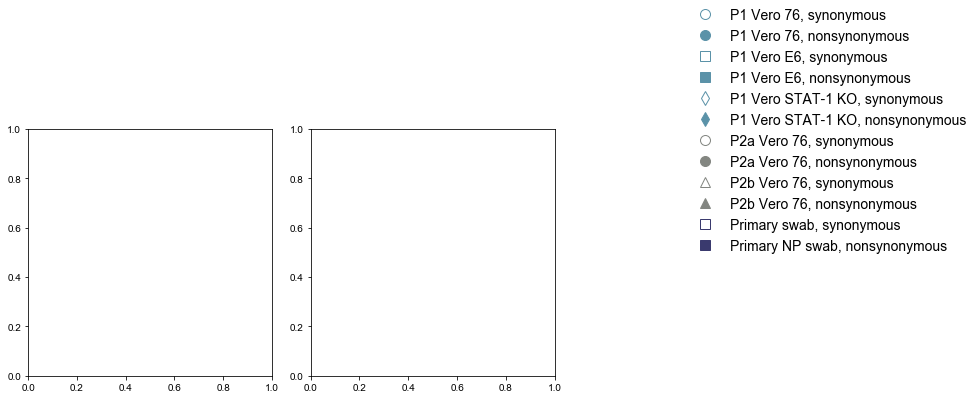

In [23]:
# ORF1a WITH LEGEND
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(8,4), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(1, 12)

ax1 = fig.add_subplot(gs[0,0:6]) #ORF1a Illumina
ax2 = fig.add_subplot(gs[0,6:12]) #ORF1a ONT

# add a legend to this plot
a = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=p1_vero76_Illumina, linestyle='None', markersize=10, label='P1 Vero 76, synonymous')
b = mlines.Line2D([], [], marker='o', markerfacecolor=p1_vero76_Illumina, markeredgecolor=p1_vero76_Illumina, linestyle='None', markersize=10, label='P1 Vero 76, nonsynonymous')
c = mlines.Line2D([], [], marker='s', markerfacecolor='None', markeredgecolor=p1_veroE6_Illumina, linestyle='None', markersize=10, label='P1 Vero E6, synonymous')
d = mlines.Line2D([], [], marker='s', markerfacecolor=p1_veroE6_Illumina, markeredgecolor=p1_veroE6_Illumina, linestyle='None', markersize=10, label='P1 Vero E6, nonsynonymous')
e = mlines.Line2D([], [], marker='d', markerfacecolor='None', markeredgecolor=p1_veroSTAT1KO_Illumina, linestyle='None', markersize=10, label='P1 Vero STAT-1 KO, synonymous')
f = mlines.Line2D([], [], marker='d', markerfacecolor=p1_veroSTAT1KO_Illumina, markeredgecolor=p1_veroSTAT1KO_Illumina, linestyle='None', markersize=10, label='P1 Vero STAT-1 KO, nonsynonymous')
g = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=p2a_vero76_Illumina, linestyle='None', markersize=10, label='P2a Vero 76, synonymous')
h = mlines.Line2D([], [], marker='o', markerfacecolor=p2b_vero76_Illumina, markeredgecolor=p2b_vero76_Illumina, linestyle='None', markersize=10, label='P2a Vero 76, nonsynonymous')
i = mlines.Line2D([], [], marker='^', markerfacecolor='None', markeredgecolor=p2b_vero76_Illumina, linestyle='None', markersize=10, label='P2b Vero 76, synonymous')
j = mlines.Line2D([], [], marker='^', markerfacecolor=p2b_vero76_Illumina, markeredgecolor=p2b_vero76_Illumina, linestyle='None', markersize=10, label='P2b Vero 76, nonsynonymous')
k = mlines.Line2D([], [], marker='s', markerfacecolor='None', markeredgecolor=primary_NP_swab_Illumina, linestyle='None', markersize=10, label='Primary swab, synonymous')
l = mlines.Line2D([], [], marker='s', markerfacecolor=primary_NP_swab_Illumina, markeredgecolor=primary_NP_swab_Illumina, linestyle='None', markersize=10, label='Primary NP swab, nonsynonymous')

fig.legend(handles=[a,b,c,d,e,f,g,h,i,j,k,l], frameon=False, fontsize=14, bbox_to_anchor=(1.7,1.4))

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../../figures/SNV_legend.pdf", bbox_inches='tight', dpi=300)


/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


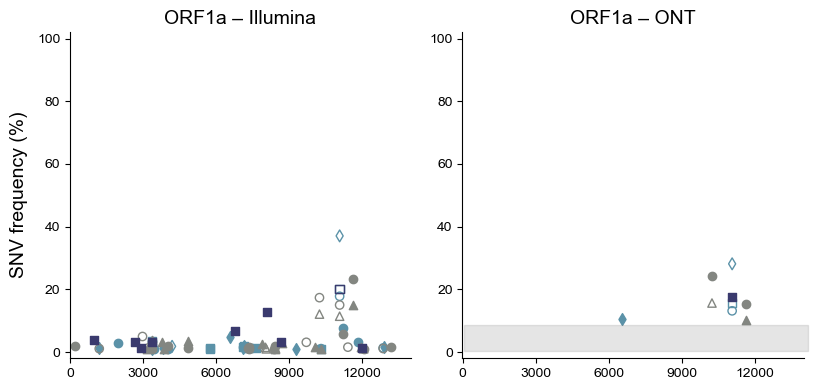

In [24]:
# ORF1a WITHOUT LEGEND
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(8,4), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(1, 12)

ax1 = fig.add_subplot(gs[0,0:6]) #ORF1a Illumina
ax2 = fig.add_subplot(gs[0,6:12]) #ORF1a ONT

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# ORF1a (ax1) 
ax1.set_title('ORF1a – Illumina', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-2,102)
ax1.set_xlim(-2,14000)
ax1.set_xticks([0, 3000, 6000, 9000, 12000])
ax1.scatter(x=p1_vero76_Illumina_ORF1a_syn['loc'], y=p1_vero76_Illumina_ORF1a_syn['% of population'], marker='o', facecolors='none', edgecolors=p1_vero76_Illumina)
ax1.scatter(x=p1_vero76_Illumina_ORF1a_nonsyn['loc'], y=p1_vero76_Illumina_ORF1a_nonsyn['% of population'], marker='o', facecolors=p1_vero76_Illumina, edgecolors=p1_vero76_Illumina)
ax1.scatter(x=p1_veroE6_Illumina_ORF1a_syn['loc'], y=p1_veroE6_Illumina_ORF1a_syn['% of population'], marker='s', facecolors='none', edgecolors=p1_veroE6_Illumina)
ax1.scatter(x=p1_veroE6_Illumina_ORF1a_nonsyn['loc'], y=p1_veroE6_Illumina_ORF1a_nonsyn['% of population'], marker='s', facecolors=p1_veroE6_Illumina, edgecolors=p1_veroE6_Illumina)
ax1.scatter(x=p1_veroSTAT1KO_Illumina_ORF1a_syn['loc'], y=p1_veroSTAT1KO_Illumina_ORF1a_syn['% of population'], marker='d', facecolors='none', edgecolors=p1_veroSTAT1KO_Illumina)
ax1.scatter(x=p1_veroSTAT1KO_Illumina_ORF1a_nonsyn['loc'], y=p1_veroSTAT1KO_Illumina_ORF1a_nonsyn['% of population'], marker='d', facecolors=p1_veroSTAT1KO_Illumina, edgecolors=p1_veroSTAT1KO_Illumina)
ax1.scatter(x=p2a_vero76_Illumina_ORF1a_syn['loc'], y=p2a_vero76_Illumina_ORF1a_syn['% of population'], marker='o', facecolors='none', edgecolors=p2a_vero76_Illumina)
ax1.scatter(x=p2a_vero76_Illumina_ORF1a_nonsyn['loc'], y=p2a_vero76_Illumina_ORF1a_nonsyn['% of population'], marker='o', facecolors=p2a_vero76_Illumina, edgecolors=p2a_vero76_Illumina)
ax1.scatter(x=p2b_vero76_Illumina_ORF1a_syn['loc'], y=p2b_vero76_Illumina_ORF1a_syn['% of population'], marker='^', facecolors='none', edgecolors=p2b_vero76_Illumina)
ax1.scatter(x=p2b_vero76_Illumina_ORF1a_nonsyn['loc'], y=p2b_vero76_Illumina_ORF1a_nonsyn['% of population'], marker='^', facecolors=p2b_vero76_Illumina, edgecolors=p2b_vero76_Illumina)
ax1.scatter(x=primary_NP_swab_Illumina_ORF1a_syn['loc'], y=primary_NP_swab_Illumina_ORF1a_syn['% of population'], marker='s', facecolors='none', edgecolors=primary_NP_swab_Illumina)
ax1.scatter(x=primary_NP_swab_Illumina_ORF1a_nonsyn['loc'], y=primary_NP_swab_Illumina_ORF1a_nonsyn['% of population'], marker='s', facecolors=primary_NP_swab_Illumina, edgecolors=primary_NP_swab_Illumina)

# ORF1a (ax2) 
ax2.set_title('ORF1a – ONT', fontname='Arial', fontsize=14)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-2,102)
ax2.set_xlim(-2,14000)
ax2.set_xticks([0, 3000, 6000, 9000, 12000])
ax2.scatter(x=p1_vero76_ONT_ORF1a_syn['loc'], y=p1_vero76_ONT_ORF1a_syn['% of population'], marker='o', facecolors='none', edgecolors=p1_vero76_ONT)
ax2.scatter(x=p1_veroE6_ONT_ORF1a_syn['loc'], y=p1_veroE6_ONT_ORF1a_syn['% of population'], marker='s', facecolors='none', edgecolors=p1_veroE6_ONT)
ax2.scatter(x=p1_veroSTAT1KO_ONT_ORF1a_nonsyn['loc'], y=p1_veroSTAT1KO_ONT_ORF1a_nonsyn['% of population'], marker='d', facecolors=p1_veroSTAT1KO_ONT, edgecolors=p1_veroSTAT1KO_ONT)
ax2.scatter(x=p1_veroSTAT1KO_ONT_ORF1a_syn['loc'], y=p1_veroSTAT1KO_ONT_ORF1a_syn['% of population'], marker='d', facecolors='none', edgecolors=p1_veroSTAT1KO_ONT)
ax2.scatter(x=p2a_vero76_ONT_ORF1a_nonsyn['loc'], y=p2a_vero76_ONT_ORF1a_nonsyn['% of population'], marker='o', facecolors=p2a_vero76_ONT, edgecolors=p2a_vero76_ONT)
ax2.scatter(x=p2b_vero76_ONT_ORF1a_nonsyn['loc'], y=p2b_vero76_ONT_ORF1a_nonsyn['% of population'], marker='^', facecolors=p2b_vero76_ONT, edgecolors=p2b_vero76_ONT)
ax2.scatter(x=p2b_vero76_ONT_ORF1a_syn['loc'], y=p2b_vero76_ONT_ORF1a_syn['% of population'], marker='^', facecolors='none', edgecolors=p2b_vero76_ONT)
ax2.scatter(x=primary_NP_swab_ONT_ORF1a_nonsyn['loc'], y=primary_NP_swab_ONT_ORF1a_nonsyn['% of population'], marker='s', facecolors=primary_NP_swab_ONT, edgecolors=primary_NP_swab_ONT)

# add a common x axis label for the entire figure 
fig.text(-0.015, 0.5, 'SNV frequency (%)', va='center', rotation='vertical', fontsize=14, fontname='Arial')

# add a grey box to the ONT plot
fig.patches.extend([plt.Rectangle((0.553,0.11),0.43,0.065, fill=True, color='grey', alpha=0.2, zorder=1000, transform=fig.transFigure, figure=fig)])

# add a legend to this plot

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../../figures/ORF1a_snvs.pdf", bbox_inches='tight', dpi=300)

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


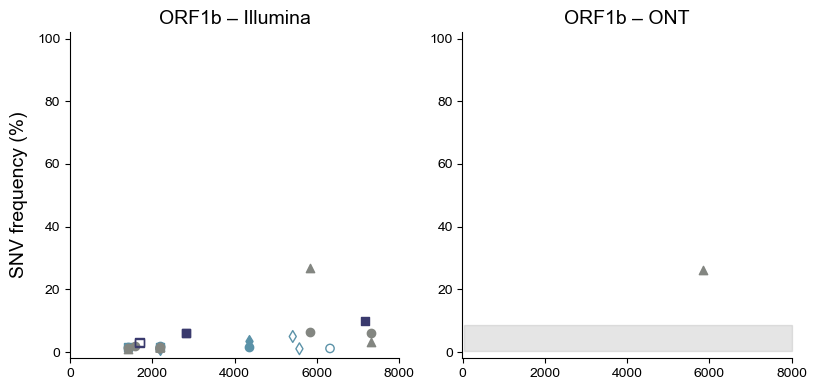

In [25]:
# ORF1b WITHOUT LEGEND
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(8,4), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(1, 12)

ax1 = fig.add_subplot(gs[0,0:6]) #ORF1b Illumina
ax2 = fig.add_subplot(gs[0,6:12]) #ORF1b ONT

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# ORF1b (ax1) 
ax1.set_title('ORF1b – Illumina', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-2,102)
ax1.set_xlim(-2,8000)
ax1.set_xticks([0, 2000, 4000, 6000, 8000])
ax1.scatter(x=p1_vero76_Illumina_ORF1b_syn['loc'], y=p1_vero76_Illumina_ORF1b_syn['% of population'], marker='o', facecolors='none', edgecolors=p1_vero76_Illumina)
ax1.scatter(x=p1_vero76_Illumina_ORF1b_nonsyn['loc'], y=p1_vero76_Illumina_ORF1b_nonsyn['% of population'], marker='o', facecolors=p1_vero76_Illumina, edgecolors=p1_vero76_Illumina)
ax1.scatter(x=p1_veroE6_Illumina_ORF1b_nonsyn['loc'], y=p1_veroE6_Illumina_ORF1b_nonsyn['% of population'], marker='s', facecolors=p1_veroE6_Illumina, edgecolors=p1_veroE6_Illumina)
ax1.scatter(x=p1_veroSTAT1KO_Illumina_ORF1b_syn['loc'], y=p1_veroSTAT1KO_Illumina_ORF1b_syn['% of population'], marker='d', facecolors='none', edgecolors=p1_veroSTAT1KO_Illumina)
ax1.scatter(x=p1_veroSTAT1KO_Illumina_ORF1b_nonsyn['loc'], y=p1_veroSTAT1KO_Illumina_ORF1b_nonsyn['% of population'], marker='d', facecolors=p1_veroSTAT1KO_Illumina, edgecolors=p1_veroSTAT1KO_Illumina)
ax1.scatter(x=p2a_vero76_Illumina_ORF1b_nonsyn['loc'], y=p2a_vero76_Illumina_ORF1b_nonsyn['% of population'], marker='o', facecolors=p2a_vero76_Illumina, edgecolors=p2a_vero76_Illumina)
ax1.scatter(x=p2a_vero76_Illumina_ORF1b_syn['loc'], y=p2a_vero76_Illumina_ORF1b_syn['% of population'], marker='o', facecolors='none', edgecolors=p2a_vero76_Illumina)
ax1.scatter(x=p2b_vero76_Illumina_ORF1b_syn['loc'], y=p2b_vero76_Illumina_ORF1b_syn['% of population'], marker='^', facecolors='none', edgecolors=p2b_vero76_Illumina)
ax1.scatter(x=p2b_vero76_Illumina_ORF1b_nonsyn['loc'], y=p2b_vero76_Illumina_ORF1b_nonsyn['% of population'], marker='^', facecolors=p2b_vero76_Illumina, edgecolors=p2b_vero76_Illumina)
ax1.scatter(x=primary_NP_swab_Illumina_ORF1b_syn['loc'], y=primary_NP_swab_Illumina_ORF1b_syn['% of population'], marker='s', facecolors='none', edgecolors=primary_NP_swab_Illumina)
ax1.scatter(x=primary_NP_swab_Illumina_ORF1b_nonsyn['loc'], y=primary_NP_swab_Illumina_ORF1b_nonsyn['% of population'], marker='s', facecolors=primary_NP_swab_Illumina, edgecolors=primary_NP_swab_Illumina)

# ORF1b (ax2) 
ax2.set_title('ORF1b – ONT', fontname='Arial', fontsize=14)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-2,102)
ax2.set_xlim(-2,8000)
ax2.set_xticks([0, 2000, 4000, 6000, 8000])
ax2.scatter(x=p2b_vero76_ONT_ORF1b_nonsyn['loc'], y=p2b_vero76_ONT_ORF1b_nonsyn['% of population'], marker='^', facecolors=p2b_vero76_ONT, edgecolors=p2b_vero76_ONT)

# add a common x axis label for the entire figure 
fig.text(-0.015, 0.5, 'SNV frequency (%)', va='center', rotation='vertical', fontsize=14, fontname='Arial')

# add a grey box to the ONT plot
fig.patches.extend([plt.Rectangle((0.553,0.11),0.41,0.065, fill=True, color='grey', alpha=0.2, zorder=1000, transform=fig.transFigure, figure=fig)])

# add a legend to this plot

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../../figures/ORF1b_snvs.pdf", bbox_inches='tight', dpi=300)

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


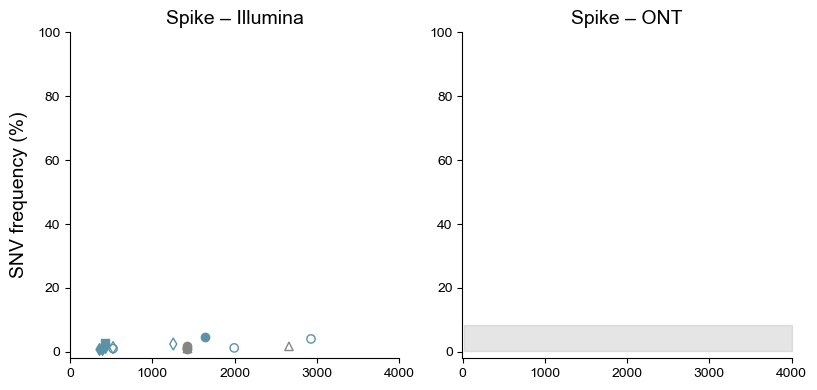

In [26]:
# S WITHOUT LEGEND
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(8,4), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(1, 12)

ax1 = fig.add_subplot(gs[0,0:6]) #S Illumina
ax2 = fig.add_subplot(gs[0,6:12]) #S ONT

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# S (ax1) 
ax1.set_title('Spike – Illumina', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-2,100)
ax1.set_xlim(-2,4000)
ax1.set_xticks([0, 1000, 2000, 3000, 4000])
ax1.scatter(x=p1_vero76_Illumina_S_syn['loc'], y=p1_vero76_Illumina_S_syn['% of population'], marker='o', facecolors='none', edgecolors=p1_vero76_Illumina)
ax1.scatter(x=p1_vero76_Illumina_S_nonsyn['loc'], y=p1_vero76_Illumina_S_nonsyn['% of population'], marker='o', facecolors=p1_vero76_Illumina, edgecolors=p1_vero76_Illumina)
ax1.scatter(x=p1_veroE6_Illumina_S_nonsyn['loc'], y=p1_veroE6_Illumina_S_nonsyn['% of population'], marker='s', facecolors=p1_veroE6_Illumina, edgecolors=p1_veroE6_Illumina)
ax1.scatter(x=p1_veroSTAT1KO_Illumina_S_syn['loc'], y=p1_veroSTAT1KO_Illumina_S_syn['% of population'], marker='d', facecolors='none', edgecolors=p1_veroSTAT1KO_Illumina)
ax1.scatter(x=p1_veroSTAT1KO_Illumina_S_nonsyn['loc'], y=p1_veroSTAT1KO_Illumina_S_nonsyn['% of population'], marker='d', facecolors=p1_veroSTAT1KO_Illumina, edgecolors=p1_veroSTAT1KO_Illumina)
ax1.scatter(x=p2a_vero76_Illumina_S_syn['loc'], y=p2a_vero76_Illumina_S_syn['% of population'], marker='o', facecolors='none', edgecolors=p2a_vero76_Illumina)
ax1.scatter(x=p2a_vero76_Illumina_S_nonsyn['loc'], y=p2a_vero76_Illumina_S_nonsyn['% of population'], marker='o', facecolors=p2a_vero76_Illumina, edgecolors=p2a_vero76_Illumina)
ax1.scatter(x=p2b_vero76_Illumina_S_syn['loc'], y=p2b_vero76_Illumina_S_syn['% of population'], marker='^', facecolors='none', edgecolors=p2b_vero76_Illumina)
ax1.scatter(x=p2b_vero76_Illumina_S_nonsyn['loc'], y=p2b_vero76_Illumina_S_nonsyn['% of population'], marker='^', facecolors=p2b_vero76_Illumina, edgecolors=p2b_vero76_Illumina)

# S (ax2) 
ax2.set_title('Spike – ONT', fontname='Arial', fontsize=14)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-2,100)
ax2.set_xlim(-2,4000)
ax2.set_xticks([0, 1000, 2000, 3000, 4000])

# add a common x axis label for the entire figure 
fig.text(-0.015, 0.5, 'SNV frequency (%)', va='center', rotation='vertical', fontsize=14, fontname='Arial')

# add a grey box to the ONT plot
fig.patches.extend([plt.Rectangle((0.553,0.11),0.41,0.065, fill=True, color='grey', alpha=0.2, zorder=1000, transform=fig.transFigure, figure=fig)])

# add a legend to this plot

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../../figures/S_snvs.pdf", bbox_inches='tight', dpi=300)

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


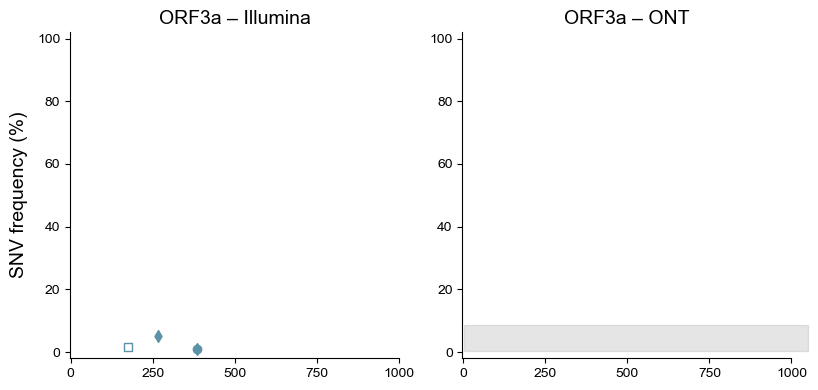

In [27]:
# ORF3a WITHOUT LEGEND
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(8,4), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(1, 12)

ax1 = fig.add_subplot(gs[0,0:6]) #ORF3a Illumina
ax2 = fig.add_subplot(gs[0,6:12]) #ORF3a ONT

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# ORF3a (ax1) 
ax1.set_title('ORF3a – Illumina', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-2,102)
ax1.set_xlim(-2,1000)
ax1.set_xticks([0, 250, 500, 750, 1000])
ax1.scatter(x=p1_vero76_Illumina_ORF3a_nonsyn['loc'], y=p1_vero76_Illumina_ORF3a_nonsyn['% of population'], marker='o', facecolors=p1_vero76_Illumina, edgecolors=p1_vero76_Illumina)
ax1.scatter(x=p1_veroE6_Illumina_ORF3a_syn['loc'], y=p1_veroE6_Illumina_ORF3a_syn['% of population'], marker='s', facecolors='none', edgecolors=p1_veroE6_Illumina)
ax1.scatter(x=p1_veroSTAT1KO_Illumina_ORF3a_nonsyn['loc'], y=p1_veroSTAT1KO_Illumina_ORF3a_nonsyn['% of population'], marker='d', facecolors=p1_veroSTAT1KO_Illumina, edgecolors=p1_veroSTAT1KO_Illumina)

# ORF3a (ax2) 
ax2.set_title('ORF3a – ONT', fontname='Arial', fontsize=14)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-2,102)
ax2.set_xlim(-2,1000)
ax2.set_xticks([0, 250, 500, 750, 1000])

# add a common x axis label for the entire figure 
fig.text(-0.015, 0.5, 'SNV frequency (%)', va='center', rotation='vertical', fontsize=14, fontname='Arial')

# add a grey box to the ONT plot
fig.patches.extend([plt.Rectangle((0.553,0.11),0.43,0.065, fill=True, color='grey', alpha=0.2, zorder=1000, transform=fig.transFigure, figure=fig)])

# add a legend to this plot

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../../figures/ORF3a_snvs.pdf", bbox_inches='tight', dpi=300)

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


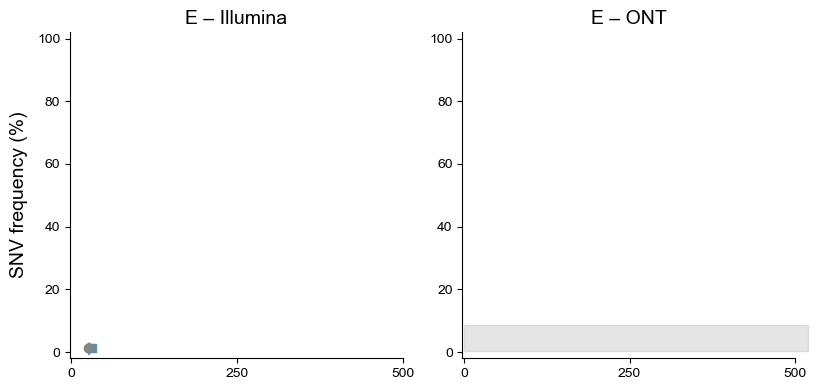

In [28]:
# E WITHOUT LEGEND
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(8,4), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(1, 12)

ax1 = fig.add_subplot(gs[0,0:6]) #E Illumina
ax2 = fig.add_subplot(gs[0,6:12]) #E ONT

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# E (ax1) 
ax1.set_title('E – Illumina', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-2,102)
ax1.set_xlim(-2,500)
ax1.set_xticks([0, 250, 500])
ax1.scatter(x=p1_veroE6_Illumina_E_nonsyn['loc'], y=p1_veroE6_Illumina_E_nonsyn['% of population'], marker='s', facecolors=p1_veroE6_Illumina, edgecolors=p1_veroE6_Illumina)
ax1.scatter(x=p1_veroSTAT1KO_Illumina_E_syn['loc'], y=p1_veroSTAT1KO_Illumina_E_syn['% of population'], marker='d', facecolors='none', edgecolors=p1_veroSTAT1KO_Illumina)
ax1.scatter(x=p2a_vero76_Illumina_E_nonsyn['loc'], y=p2a_vero76_Illumina_E_nonsyn['% of population'], marker='o', facecolors=p2a_vero76_Illumina, edgecolors=p2a_vero76_Illumina)
ax1.scatter(x=p2a_vero76_Illumina_E_syn['loc'], y=p2a_vero76_Illumina_E_syn['% of population'], marker='o', facecolors='none', edgecolors=p2a_vero76_Illumina)

# E (ax2) 
ax2.set_title('E – ONT', fontname='Arial', fontsize=14)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-2,102)
ax2.set_xlim(-2,500)
ax2.set_xticks([0, 250, 500])

# add a common x axis label for the entire figure 
fig.text(-0.015, 0.5, 'SNV frequency (%)', va='center', rotation='vertical', fontsize=14, fontname='Arial')

# add a grey box to the ONT plot
fig.patches.extend([plt.Rectangle((0.553,0.11),0.43,0.065, fill=True, color='grey', alpha=0.2, zorder=1000, transform=fig.transFigure, figure=fig)])

# add a legend to this plot

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../../figures/E_snvs.pdf", bbox_inches='tight', dpi=300)

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


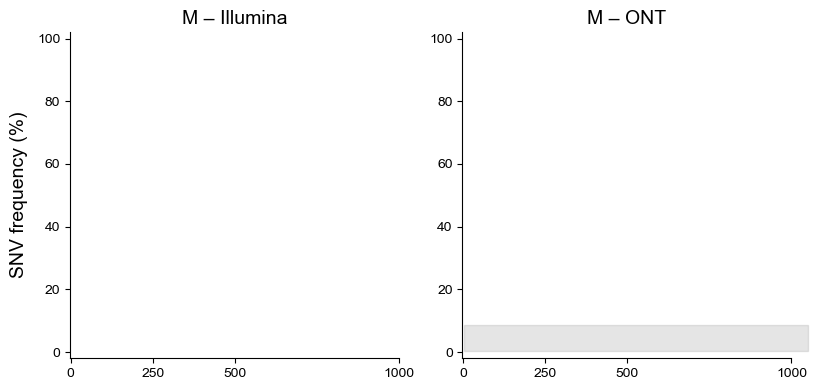

In [29]:
# M WITHOUT LEGEND
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(8,4), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(1, 12)

ax1 = fig.add_subplot(gs[0,0:6]) #M Illumina
ax2 = fig.add_subplot(gs[0,6:12]) #M ONT

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# M (ax1) 
ax1.set_title('M – Illumina', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-2,102)
ax1.set_xlim(-2,1000)
ax1.set_xticks([0, 250, 500, 1000])

# M (ax2) 
ax2.set_title('M – ONT', fontname='Arial', fontsize=14)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-2,102)
ax2.set_xlim(-2,1000)
ax2.set_xticks([0, 250, 500, 1000])

# add a common x axis label for the entire figure 
fig.text(-0.015, 0.5, 'SNV frequency (%)', va='center', rotation='vertical', fontsize=14, fontname='Arial')

# add a grey box to the ONT plot
fig.patches.extend([plt.Rectangle((0.553,0.11),0.43,0.065, fill=True, color='grey', alpha=0.2, zorder=1000, transform=fig.transFigure, figure=fig)])

# add a legend to this plot

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../../figures/M_snvs.pdf", bbox_inches='tight', dpi=300)

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


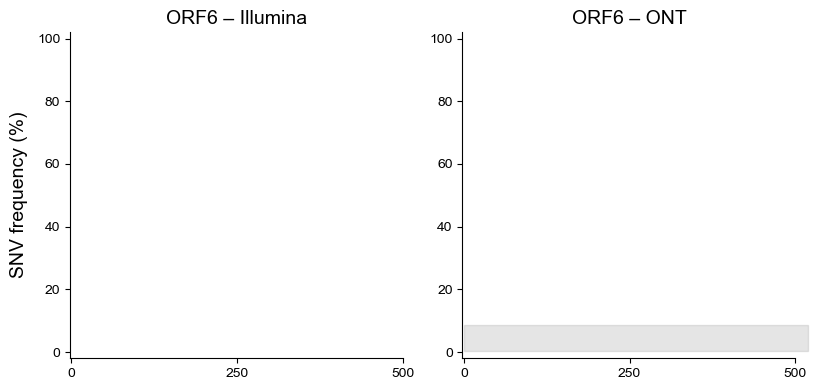

In [30]:
# ORF6 WITHOUT LEGEND
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(8,4), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(1, 12)

ax1 = fig.add_subplot(gs[0,0:6]) #ORF6 Illumina
ax2 = fig.add_subplot(gs[0,6:12]) #ORF6 ONT

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# ORF6 (ax1) 
ax1.set_title('ORF6 – Illumina', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-2,102)
ax1.set_xlim(-2,500)
ax1.set_xticks([0, 250, 500])

# ORF6 (ax2) 
ax2.set_title('ORF6 – ONT', fontname='Arial', fontsize=14)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-2,102)
ax2.set_xlim(-2,500)
ax2.set_xticks([0, 250, 500])

# add a common x axis label for the entire figure 
fig.text(-0.015, 0.5, 'SNV frequency (%)', va='center', rotation='vertical', fontsize=14, fontname='Arial')

# add a grey box to the ONT plot
fig.patches.extend([plt.Rectangle((0.553,0.11),0.43,0.065, fill=True, color='grey', alpha=0.2, zorder=1000, transform=fig.transFigure, figure=fig)])

# add a legend to this plot

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../../figures/ORF6_snvs.pdf", bbox_inches='tight', dpi=300)

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


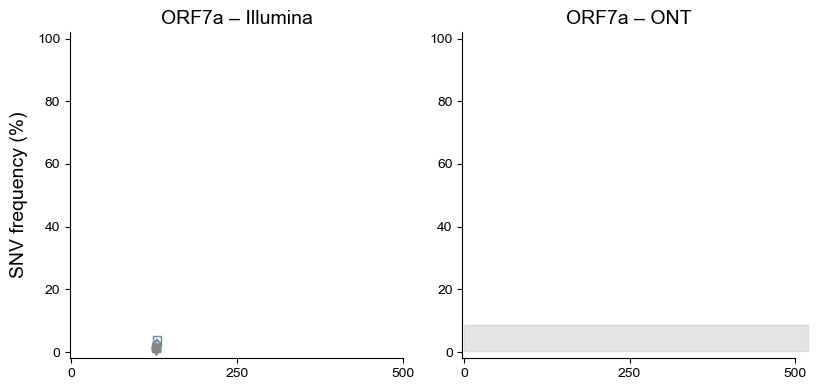

In [31]:
# ORF7a WITHOUT LEGEND
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(8,4), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(1, 12)

ax1 = fig.add_subplot(gs[0,0:6]) #ORF7a Illumina
ax2 = fig.add_subplot(gs[0,6:12]) #ORF7a ONT

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# ORF7a (ax1) 
ax1.set_title('ORF7a – Illumina', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-2,102)
ax1.set_xlim(-2,500)
ax1.set_xticks([0, 250, 500])
ax1.scatter(x=p1_vero76_Illumina_ORF7a_syn['loc'], y=p1_vero76_Illumina_ORF7a_syn['% of population'], marker='o', facecolors='none', edgecolors=p1_vero76_Illumina)
ax1.scatter(x=p1_vero76_Illumina_ORF7a_nonsyn['loc'], y=p1_vero76_Illumina_ORF7a_nonsyn['% of population'], marker='o', facecolors=p1_vero76_Illumina, edgecolors=p1_vero76_Illumina)
ax1.scatter(x=p1_veroE6_Illumina_ORF7a_syn['loc'], y=p1_veroE6_Illumina_ORF7a_syn['% of population'], marker='s', facecolors='none', edgecolors=p1_veroE6_Illumina)
ax1.scatter(x=p1_veroE6_Illumina_ORF7a_nonsyn['loc'], y=p1_veroE6_Illumina_ORF7a_nonsyn['% of population'], marker='s', facecolors=p1_veroE6_Illumina, edgecolors=p1_veroE6_Illumina)
ax1.scatter(x=p1_veroSTAT1KO_Illumina_ORF7a_syn['loc'], y=p1_veroSTAT1KO_Illumina_ORF7a_syn['% of population'], marker='d', facecolors='none', edgecolors=p1_veroSTAT1KO_Illumina)
ax1.scatter(x=p1_veroSTAT1KO_Illumina_ORF7a_nonsyn['loc'], y=p1_veroSTAT1KO_Illumina_ORF7a_nonsyn['% of population'], marker='d', facecolors=p1_veroSTAT1KO_Illumina, edgecolors=p1_veroSTAT1KO_Illumina)
ax1.scatter(x=p2a_vero76_Illumina_ORF7a_syn['loc'], y=p2a_vero76_Illumina_ORF7a_syn['% of population'], marker='o', facecolors='none', edgecolors=p2a_vero76_Illumina)
ax1.scatter(x=p2a_vero76_Illumina_ORF7a_nonsyn['loc'], y=p2a_vero76_Illumina_ORF7a_nonsyn['% of population'], marker='o', facecolors=p2a_vero76_Illumina, edgecolors=p2a_vero76_Illumina)
ax1.scatter(x=p2b_vero76_Illumina_ORF7a_syn['loc'], y=p2b_vero76_Illumina_ORF7a_syn['% of population'], marker='^', facecolors='none', edgecolors=p2b_vero76_Illumina)
ax1.scatter(x=p2b_vero76_Illumina_ORF7a_nonsyn['loc'], y=p2b_vero76_Illumina_ORF7a_nonsyn['% of population'], marker='^', facecolors=p2b_vero76_Illumina, edgecolors=p2b_vero76_Illumina)

# ORF7a (ax2) 
ax2.set_title('ORF7a – ONT', fontname='Arial', fontsize=14)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-2,102)
ax2.set_xlim(-2,500)
ax2.set_xticks([0, 250, 500])

# add a common x axis label for the entire figure 
fig.text(-0.015, 0.5, 'SNV frequency (%)', va='center', rotation='vertical', fontsize=14, fontname='Arial')

# add a grey box to the ONT plot
fig.patches.extend([plt.Rectangle((0.553,0.11),0.43,0.065, fill=True, color='grey', alpha=0.2, zorder=1000, transform=fig.transFigure, figure=fig)])

# add a legend to this plot

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../../figures/ORF7a_snvs.pdf", bbox_inches='tight', dpi=300)

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


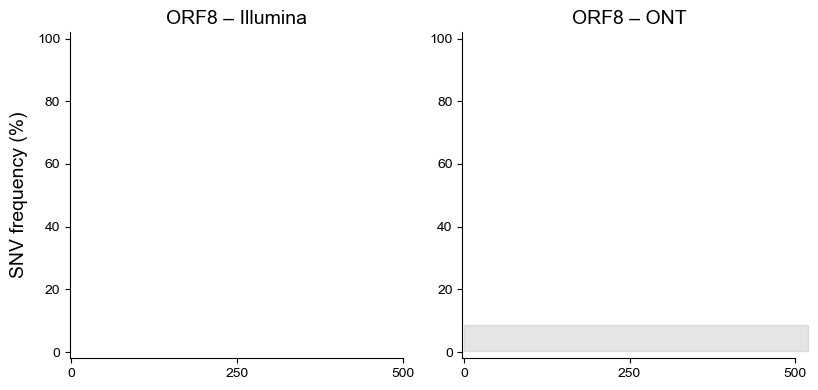

In [32]:
# ORF8 WITHOUT LEGEND
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(8,4), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(1, 12)

ax1 = fig.add_subplot(gs[0,0:6]) #ORF8 Illumina
ax2 = fig.add_subplot(gs[0,6:12]) #ORF8 ONT

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# ORF8 (ax1) 
ax1.set_title('ORF8 – Illumina', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-2,102)
ax1.set_xlim(-2,500)
ax1.set_xticks([0, 250, 500])

# ORF8 (ax2) 
ax2.set_title('ORF8 – ONT', fontname='Arial', fontsize=14)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-2,102)
ax2.set_xlim(-2,500)
ax2.set_xticks([0, 250, 500])

# add a common x axis label for the entire figure 
fig.text(-0.015, 0.5, 'SNV frequency (%)', va='center', rotation='vertical', fontsize=14, fontname='Arial')

# add a grey box to the ONT plot
fig.patches.extend([plt.Rectangle((0.553,0.11),0.43,0.065, fill=True, color='grey', alpha=0.2, zorder=1000, transform=fig.transFigure, figure=fig)])

# add a legend to this plot

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../../figures/ORF8_snvs.pdf", bbox_inches='tight', dpi=300)

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


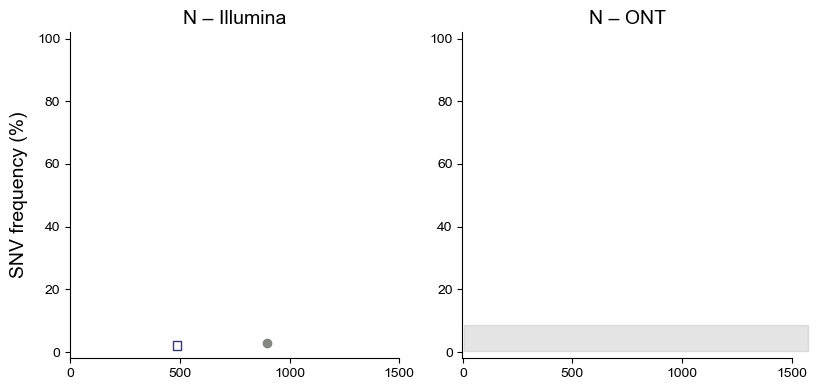

In [33]:
# N WITHOUT LEGEND
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(8,4), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(1, 12)

ax1 = fig.add_subplot(gs[0,0:6]) #N Illumina
ax2 = fig.add_subplot(gs[0,6:12]) #N ONT

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# N (ax1) 
ax1.set_title('N – Illumina', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-2,102)
ax1.set_xlim(-2,1500)
ax1.set_xticks([0, 500, 1000, 1500])
ax1.scatter(x=p2a_vero76_Illumina_N_nonsyn['loc'], y=p2a_vero76_Illumina_N_nonsyn['% of population'], marker='o', facecolors=p2a_vero76_Illumina, edgecolors=p2a_vero76_Illumina)
ax1.scatter(x=primary_NP_swab_Illumina_N_syn['loc'], y=primary_NP_swab_Illumina_N_syn['% of population'], marker='s', facecolors='none', edgecolors=primary_NP_swab_Illumina)

# N (ax2) 
ax2.set_title('N – ONT', fontname='Arial', fontsize=14)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-2,102)
ax2.set_xlim(-2,1500)
ax2.set_xticks([0, 500, 1000, 1500])

# add a common x axis label for the entire figure 
fig.text(-0.015, 0.5, 'SNV frequency (%)', va='center', rotation='vertical', fontsize=14, fontname='Arial')

# add a grey box to the ONT plot
fig.patches.extend([plt.Rectangle((0.553,0.11),0.43,0.065, fill=True, color='grey', alpha=0.2, zorder=1000, transform=fig.transFigure, figure=fig)])

# add a legend to this plot

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../../figures/N_snvs.pdf", bbox_inches='tight', dpi=300)

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


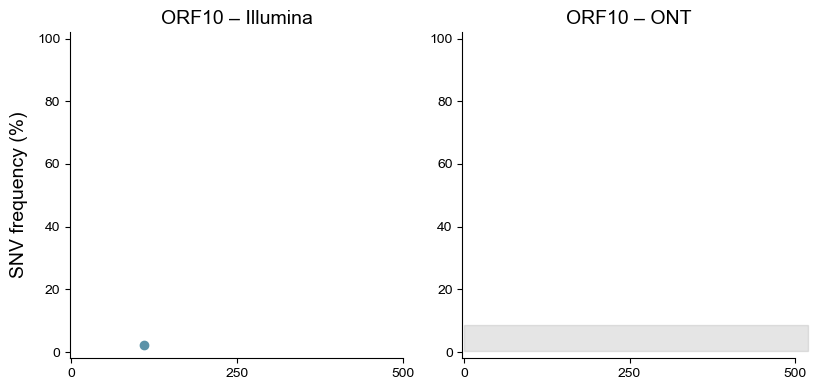

In [34]:
# ORF10 WITHOUT LEGEND
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(8,4), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(1, 12)

ax1 = fig.add_subplot(gs[0,0:6]) #ORF10 Illumina
ax2 = fig.add_subplot(gs[0,6:12]) #ORF10 ONT

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# ORF10 (ax1) 
ax1.set_title('ORF10 – Illumina', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-2,102)
ax1.set_xlim(-2,500)
ax1.set_xticks([0, 250, 500])
ax1.scatter(x=p1_vero76_Illumina_ORF10_nonsyn['loc'], y=p1_vero76_Illumina_ORF10_nonsyn['% of population'], marker='o', facecolors=p1_vero76_Illumina, edgecolors=p1_vero76_Illumina)

# ORF10 (ax2) 
ax2.set_title('ORF10 – ONT', fontname='Arial', fontsize=14)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-2,102)
ax2.set_xlim(-2,500)
ax2.set_xticks([0, 250, 500])

# add a common x axis label for the entire figure 
fig.text(-0.015, 0.5, 'SNV frequency (%)', va='center', rotation='vertical', fontsize=14, fontname='Arial')

# add a grey box to the ONT plot
fig.patches.extend([plt.Rectangle((0.553,0.11),0.43,0.065, fill=True, color='grey', alpha=0.2, zorder=1000, transform=fig.transFigure, figure=fig)])

# add a legend to this plot

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../../figures/ORF10_snvs.pdf", bbox_inches='tight', dpi=300)

# Taking a look at SNVs over time 

I want to look at the SNV frequency of SNVs found in the primary swab, as well as P1 and P2.  
I'll also look at *de novo* SNVs found in P1 that are then also found in P2.  

In [35]:
# load cleaned VCF files into dataframes

primary_NP_swab = pd.read_csv('VCFs_Illumina/cleaned/primary_NP_swab-cleaned.csv', sep='\t')
primary_NP_swab = primary_NP_swab.rename(columns={'FREQ':'freq_primary_NP_swab'})
primary_NP_swab = primary_NP_swab[['SNP', 'freq_primary_NP_swab']]

p1_vero76 = pd.read_csv('VCFs_Illumina/cleaned/p1_vero76-cleaned.csv', sep='\t')
p1_vero76 = p1_vero76.rename(columns={'FREQ':'freq_p1_vero76'})
p1_vero76 = p1_vero76[['SNP', 'freq_p1_vero76']]

p1_veroE6 = pd.read_csv('VCFs_Illumina/cleaned/p1_veroE6-cleaned.csv', sep='\t')
p1_veroE6 = p1_veroE6.rename(columns={'FREQ':'freq_p1_veroE6'})
p1_veroE6 = p1_veroE6[['SNP', 'freq_p1_veroE6']]

p1_veroSTAT1KO = pd.read_csv('VCFs_Illumina/cleaned/p1_veroSTAT1KO-cleaned.csv', sep='\t')
p1_veroSTAT1KO = p1_veroSTAT1KO.rename(columns={'FREQ':'freq_p1_veroSTAT1KO'})
p1_veroSTAT1KO = p1_veroSTAT1KO[['SNP', 'freq_p1_veroSTAT1KO']]

p2a_vero76 = pd.read_csv('VCFs_Illumina/cleaned/p2a_vero76-cleaned.csv', sep='\t')
p2a_vero76 = p2a_vero76.rename(columns={'FREQ':'freq_p2a_vero76'})
p2a_vero76 = p2a_vero76[['SNP', 'freq_p2a_vero76']]

p2b_vero76 = pd.read_csv('VCFs_Illumina/cleaned/p2b_vero76-cleaned.csv', sep='\t')
p2b_vero76 = p2b_vero76.rename(columns={'FREQ':'freq_p2b_vero76'})
p2b_vero76 = p2b_vero76[['SNP', 'freq_p2b_vero76']]

#

In [36]:
# merge dataframes
pd.set_option("display.precision", 4)

temp = pd.merge(primary_NP_swab, p1_vero76, on='SNP', how='outer')
temp1 = pd.merge(temp, p1_veroE6, on='SNP', how='outer')
temp2 = pd.merge(temp1, p1_veroSTAT1KO, on='SNP', how='outer')
temp3 = pd.merge(temp2, p2a_vero76, on='SNP', how='outer')
merged = pd.merge(temp3, p2b_vero76, on='SNP', how='outer')

merged = merged.dropna(thresh=3) # drop rows with >3 Nans (no overlap in SNVs)
merged = merged.replace(np.nan, '', regex=True) # replace NaN values with empty strings
merged.to_csv('VCFs_Illumina/shared_SNVs/shared_SNVs.csv', sep=',')

merged

,SNP,freq_primary_NP_swab,freq_p1_vero76,freq_p1_veroE6,freq_p1_veroSTAT1KO,freq_p2a_vero76,freq_p2b_vero76
3,ORF1a_T3353C_V1118A,0.0332,0.0359,0.0352,0.0217,0.0316,0.038
7,ORF1a_G11070T_syn,0.2,0.1778,0.2021,0.3705,0.15,0.1142
16,ORF1a_G3356A_G1119D,,0.0166,0.0112,0.0101,0.0101,0.0169
18,ORF1a_A4043G_K1348R,,0.0103,,,0.0192,
19,ORF1a_T7121C_M2374T,,0.0149,0.0163,0.0136,,
20,ORF1a_G7123A_A2375T,,0.0189,0.0177,0.0191,,
24,ORF1a_T12858C_syn,,0.013,,,0.0111,
25,ORF1b_A1420G_R474G,,0.0149,0.0149,,0.0112,0.0103
26,ORF1b_G2190A_syn,,0.011,,,,0.0127
27,ORF1b_G2191A_A731T,,0.0182,0.0162,0.0111,0.0159,0.0149


/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


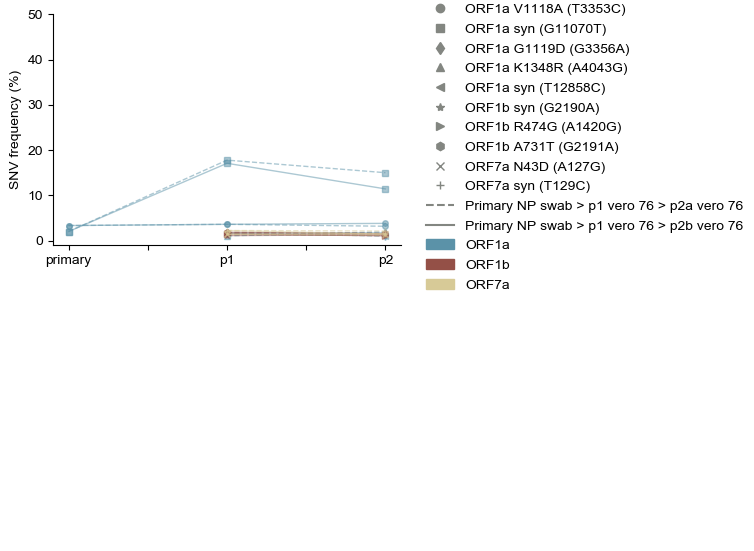

In [37]:
# This function generates an array/matrix from a series of SNV frequencies 
def splitSerToArr(ser):
    return [ser.index, ser.as_matrix()]

# define possible routes per SNV: 
# route 1: swab --> p1 vero 76 --> p2a vero 76
# route 2: swab --> p1 vero 76 --> p2b vero 76 

# route 1 = dash line
# route 2 = solid line 
# symbol = SNV
# color = gene 

# These SNV frequencies are pulled from the VCF files in `data_derived`
xs = range(3)

series1 = [3.32, 3.59, 3.16] # ORF1a_T3353C_V1118A route 1
series2 = [3.32, 3.59, 3.80] # ORF1a_T3353C_V1118A route 2

series5 = [2.0, 17.78, 15.00] # ORF1a_G11070T_syn route 1
series6 = [2.0, 17.078, 11.42] # ORF1a_G11070T_syn route 2

series9 = [None, 1.66, 1.01] # ORF1a_G3356A_G1119D route 1
series10 = [None, 1.66, 1.69] # ORF1a_G3356A_G1119D route 2

series3 = [None, 1.03, 1.92] # ORF1a_A4043G_K1348R route 1

series4 = [None, 1.30, 1.11] # ORF1a_T12858C_syn route 1

series11 = [None, 1.49, 1.12] # ORF1b_A1420G_R474G route 3
series12 = [None, 1.49, 1.03] # ORF1b_A1420G_R474G route 4

series7 = [None, 1.10, 1.27] # ORF1b_G2190A_syn route 2

series13 = [None, 1.82, 1.59] # ORF1b_G2191A_A731T route 1
series14 = [None, 1.82, 1.49] # ORF1b_G2191A_A731T route 2

series15 = [None, 1.37, 1.17] # ORF7a_A127G_N43D route 1
series16 = [None, 1.37, 1.53] # ORF7a_A127G_N43D route 2

series17 = [None, 2.22, 2.11] # ORF7a_T129C_syn route 1
series18 = [None, 2.22, 1.42] # ORF7a_T129C_syn route 2


s1 = pd.Series(series1, index=xs)
s2 = pd.Series(series2, index=xs)
s3 = pd.Series(series3, index=xs)
s4 = pd.Series(series4, index=xs)
s5 = pd.Series(series5, index=xs)
s6 = pd.Series(series6, index=xs)
s7 = pd.Series(series7, index=xs)
s9 = pd.Series(series9, index=xs)
s10 = pd.Series(series10, index=xs)
s11 = pd.Series(series11, index=xs)
s12 = pd.Series(series12, index=xs)
s13 = pd.Series(series13, index=xs)
s14 = pd.Series(series14, index=xs)
s15 = pd.Series(series15, index=xs)
s16 = pd.Series(series16, index=xs)
s17 = pd.Series(series17, index=xs)
s18 = pd.Series(series18, index=xs)

# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(14,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(3, 11)

ax1 = fig.add_subplot(gs[0,0:3]) 

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
    
# set fontsize of axes  
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# edit the axes - ax1
ax1.set_title('', fontname='Arial', fontsize=14)
ax1.set_ylabel('SNV frequency (%)', fontname='Arial', fontsize=10)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-1,50)
ax1.set_yticks([0,10,20,30,40,50])
ax1.set_xticklabels(['', 'primary', '', 'p1', '', 'p2'], fontname='Arial', fontsize='10', minor=False)

# plot SNV series
ax1.plot( *splitSerToArr(s1.dropna()), linestyle='dashed', linewidth=1, alpha=0.5, marker='o', markersize=4, color='#5B92A8') # ORF1a_T3353C_V1118A route 1
ax1.plot( *splitSerToArr(s2.dropna()), linestyle='solid', linewidth=1, alpha=0.5, marker='o', markersize=4, color='#5B92A8') # ORF1a_T3353C_V1118A route 2

ax1.plot( *splitSerToArr(s5.dropna()), linestyle='dashed', linewidth=1, alpha=0.5, marker='s', markersize=4, color='#5B92A8') # ORF1a_G11070T_syn route 1
ax1.plot( *splitSerToArr(s6.dropna()), linestyle='solid', linewidth=1, alpha=0.5, marker='s', markersize=4, color='#5B92A8') # ORF1a_G11070T_syn route 2

ax1.plot( *splitSerToArr(s9.dropna()), linestyle='dashed', linewidth=1, alpha=0.5, marker='d', markersize=4, color='#5B92A8') # ORF1a_G3356A_G1119D route 1
ax1.plot( *splitSerToArr(s10.dropna()), linestyle='solid', linewidth=1, alpha=0.5, marker='d', markersize=4, color='#5B92A8') # ORF1a_G3356A_G1119D route 2

ax1.plot( *splitSerToArr(s3.dropna()), linestyle='dashed', linewidth=1, alpha=0.5, marker='^', markersize=4, color='#5B92A8') # ORF1a_A4043G_K1348R route 1

ax1.plot( *splitSerToArr(s4.dropna()), linestyle='dashed', linewidth=1, alpha=0.5, marker='<', markersize=4, color='#5B92A8') # ORF1a_T12858C_syn route 1

ax1.plot( *splitSerToArr(s11.dropna()), linestyle='dashed', linewidth=1, alpha=0.5, marker='>', markersize=4, color='#945047') # ORF1b_A1420G_R474G route 1
ax1.plot( *splitSerToArr(s12.dropna()), linestyle='solid', linewidth=1, alpha=0.5, marker='>', markersize=4, color='#945047') # ORF1b_A1420G_R474G route 2

ax1.plot( *splitSerToArr(s7.dropna()), linestyle='solid', linewidth=1, alpha=0.5, marker='*', markersize=4, color='#945047') # ORF1b_G2190A_syn route 2

ax1.plot( *splitSerToArr(s13.dropna()), linestyle='dashed', linewidth=1, alpha=0.5, marker='h', markersize=4, color='#945047') # ORF1b_G2191A_A731T route 1
ax1.plot( *splitSerToArr(s14.dropna()), linestyle='solid', linewidth=1, alpha=0.5, marker='h', markersize=4, color='#945047') # ORF1b_G2191A_A731T route 2

ax1.plot( *splitSerToArr(s15.dropna()), linestyle='dashed', linewidth=1, alpha=0.5, marker='x', markersize=4, color='#D7CA97') # ORF7a_A127G_N43D route 1
ax1.plot( *splitSerToArr(s16.dropna()), linestyle='solid', linewidth=1, alpha=0.5, marker='x', markersize=4, color='#D7CA97') # ORF7a_A127G_N43D route 2

ax1.plot( *splitSerToArr(s17.dropna()), linestyle='dashed', linewidth=1, alpha=0.5, marker='+', markersize=4, color='#D7CA97') # ORF7a_T129C_syn route 1
ax1.plot( *splitSerToArr(s18.dropna()), linestyle='solid', linewidth=1, alpha=0.5, marker='+', markersize=4, color='#D7CA97') # ORF7a_T129C_syn route 2

# add a legend to this plot

ORF1a_T3353C_V1118A = mlines.Line2D([], [], marker='o', color='#838681', linestyle='None', markersize=6, label='ORF1a V1118A (T3353C)')
ORF1a_G11070T_syn = mlines.Line2D([], [], marker='s', color='#838681', linestyle='None', markersize=6, label='ORF1a syn (G11070T)')
ORF1a_G3356A_G1119D = mlines.Line2D([], [], marker='d', color='#838681', linestyle='None', markersize=6, label='ORF1a G1119D (G3356A)')
ORF1a_A4043G_K1348R = mlines.Line2D([], [], marker='^', color='#838681', linestyle='None', markersize=6, label='ORF1a K1348R (A4043G)')
ORF1a_T12858C_syn = mlines.Line2D([], [], marker='<', color='#838681', linestyle='None', markersize=6, label='ORF1a syn (T12858C)')
ORF1b_A1420G_R474G = mlines.Line2D([], [], marker='>', color='#838681', linestyle='None', markersize=6, label='ORF1b R474G (A1420G)')
ORF1b_G2190A_syn = mlines.Line2D([], [], marker='*', color='#838681', linestyle='None', markersize=6, label='ORF1b syn (G2190A)')
ORF1b_G2191A_A731T = mlines.Line2D([], [], marker='h', color='#838681', linestyle='None', markersize=6, label='ORF1b A731T (G2191A)')
ORF7a_A127G_N43D = mlines.Line2D([], [], marker='x', color='#838681', linestyle='None', markersize=6, label='ORF7a N43D (A127G)')
ORF7a_T129C_syn = mlines.Line2D([], [], marker='+', color='#838681', linestyle='None', markersize=6, label='ORF7a syn (T129C)')

route_1 = mlines.Line2D([], [], marker='None', color='#838681', linestyle='dashed', label='Primary NP swab > p1 vero 76 > p2a vero 76')
route_2 = mlines.Line2D([], [], marker='None', color='#838681', linestyle='solid', label='Primary NP swab > p1 vero 76 > p2b vero 76')

# color patches = route 
ORF1a = mpatches.Patch(color='#5B92A8', label='ORF1a')
ORF1b = mpatches.Patch(color='#945047', label='ORF1b')
ORF7a = mpatches.Patch(color='#D7CA97', label='ORF7a')


fig.legend(handles=[ORF1a_T3353C_V1118A, ORF1a_G11070T_syn, ORF1a_G3356A_G1119D, ORF1a_A4043G_K1348R, ORF1a_T12858C_syn, ORF1b_G2190A_syn, ORF1b_A1420G_R474G, ORF1b_G2191A_A731T, ORF7a_A127G_N43D, ORF7a_T129C_syn, route_1, route_2, ORF1a, ORF1b, ORF7a], frameon=False, fontsize=10, bbox_to_anchor=(0.54,0.7))

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../../figures/SNV-over-time.pdf", bbox_inches='tight', dpi=300)


###

/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


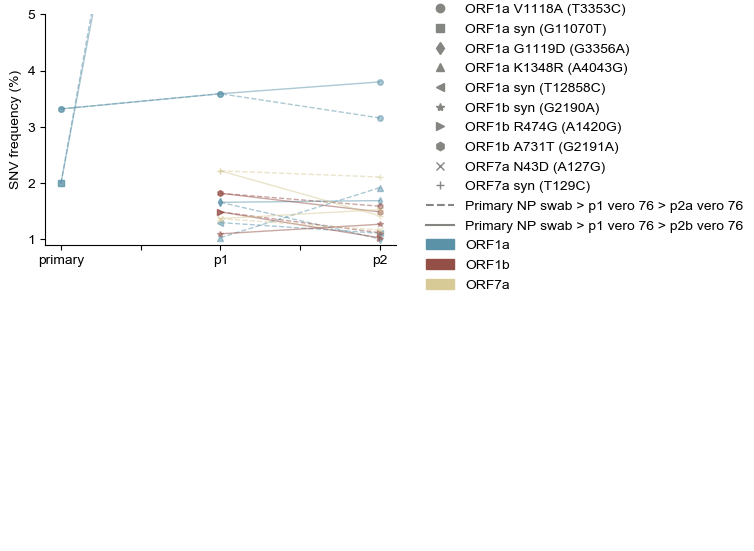

In [38]:
# This function generates an array/matrix from a series of SNV frequencies 
def splitSerToArr(ser):
    return [ser.index, ser.as_matrix()]

# define possible routes per SNV: 
# route 1: swab --> p1 vero 76 --> p2a vero 76
# route 2: swab --> p1 vero 76 --> p2b vero 76 

# route 1 = dash line
# route 2 = solid line 
# symbol = SNV
# color = gene 

# These SNV frequencies are pulled from the VCF files in `data_derived`
xs = range(3)

series1 = [3.32, 3.59, 3.16] # ORF1a_T3353C_V1118A route 1
series2 = [3.32, 3.59, 3.80] # ORF1a_T3353C_V1118A route 2

series5 = [2.0, 17.78, 15.00] # ORF1a_G11070T_syn route 1
series6 = [2.0, 17.078, 11.42] # ORF1a_G11070T_syn route 2

series9 = [None, 1.66, 1.01] # ORF1a_G3356A_G1119D route 1
series10 = [None, 1.66, 1.69] # ORF1a_G3356A_G1119D route 2

series3 = [None, 1.03, 1.92] # ORF1a_A4043G_K1348R route 1

series4 = [None, 1.30, 1.11] # ORF1a_T12858C_syn route 1

series11 = [None, 1.49, 1.12] # ORF1b_A1420G_R474G route 3
series12 = [None, 1.49, 1.03] # ORF1b_A1420G_R474G route 4

series7 = [None, 1.10, 1.27] # ORF1b_G2190A_syn route 2

series13 = [None, 1.82, 1.59] # ORF1b_G2191A_A731T route 1
series14 = [None, 1.82, 1.49] # ORF1b_G2191A_A731T route 2

series15 = [None, 1.37, 1.17] # ORF7a_A127G_N43D route 1
series16 = [None, 1.37, 1.53] # ORF7a_A127G_N43D route 2

series17 = [None, 2.22, 2.11] # ORF7a_T129C_syn route 1
series18 = [None, 2.22, 1.42] # ORF7a_T129C_syn route 2


s1 = pd.Series(series1, index=xs)
s2 = pd.Series(series2, index=xs)
s3 = pd.Series(series3, index=xs)
s4 = pd.Series(series4, index=xs)
s5 = pd.Series(series5, index=xs)
s6 = pd.Series(series6, index=xs)
s7 = pd.Series(series7, index=xs)
s9 = pd.Series(series9, index=xs)
s10 = pd.Series(series10, index=xs)
s11 = pd.Series(series11, index=xs)
s12 = pd.Series(series12, index=xs)
s13 = pd.Series(series13, index=xs)
s14 = pd.Series(series14, index=xs)
s15 = pd.Series(series15, index=xs)
s16 = pd.Series(series16, index=xs)
s17 = pd.Series(series17, index=xs)
s18 = pd.Series(series18, index=xs)

# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(14,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(3, 11)

ax1 = fig.add_subplot(gs[0,0:3]) 

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
    
# set fontsize of axes  
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# edit the axes - ax1
ax1.set_title('', fontname='Arial', fontsize=14)
ax1.set_ylabel('SNV frequency (%)', fontname='Arial', fontsize=10)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(0.9,5)
ax1.set_yticks([1,2,3,4,5])
ax1.set_xticklabels(['', 'primary', '', 'p1', '', 'p2'], fontname='Arial', fontsize='10', minor=False)

# plot SNV series
ax1.plot( *splitSerToArr(s1.dropna()), linestyle='dashed', linewidth=1, alpha=0.5, marker='o', markersize=4, color='#5B92A8') # ORF1a_T3353C_V1118A route 1
ax1.plot( *splitSerToArr(s2.dropna()), linestyle='solid', linewidth=1, alpha=0.5, marker='o', markersize=4, color='#5B92A8') # ORF1a_T3353C_V1118A route 2

ax1.plot( *splitSerToArr(s5.dropna()), linestyle='dashed', linewidth=1, alpha=0.5, marker='s', markersize=4, color='#5B92A8') # ORF1a_G11070T_syn route 1
ax1.plot( *splitSerToArr(s6.dropna()), linestyle='solid', linewidth=1, alpha=0.5, marker='s', markersize=4, color='#5B92A8') # ORF1a_G11070T_syn route 2

ax1.plot( *splitSerToArr(s9.dropna()), linestyle='dashed', linewidth=1, alpha=0.5, marker='d', markersize=4, color='#5B92A8') # ORF1a_G3356A_G1119D route 1
ax1.plot( *splitSerToArr(s10.dropna()), linestyle='solid', linewidth=1, alpha=0.5, marker='d', markersize=4, color='#5B92A8') # ORF1a_G3356A_G1119D route 2

ax1.plot( *splitSerToArr(s3.dropna()), linestyle='dashed', linewidth=1, alpha=0.5, marker='^', markersize=4, color='#5B92A8') # ORF1a_A4043G_K1348R route 1

ax1.plot( *splitSerToArr(s4.dropna()), linestyle='dashed', linewidth=1, alpha=0.5, marker='<', markersize=4, color='#5B92A8') # ORF1a_T12858C_syn route 1

ax1.plot( *splitSerToArr(s11.dropna()), linestyle='dashed', linewidth=1, alpha=0.5, marker='>', markersize=4, color='#945047') # ORF1b_A1420G_R474G route 1
ax1.plot( *splitSerToArr(s12.dropna()), linestyle='solid', linewidth=1, alpha=0.5, marker='>', markersize=4, color='#945047') # ORF1b_A1420G_R474G route 2

ax1.plot( *splitSerToArr(s7.dropna()), linestyle='solid', linewidth=1, alpha=0.5, marker='*', markersize=4, color='#945047') # ORF1b_G2190A_syn route 2

ax1.plot( *splitSerToArr(s13.dropna()), linestyle='dashed', linewidth=1, alpha=0.5, marker='h', markersize=4, color='#945047') # ORF1b_G2191A_A731T route 1
ax1.plot( *splitSerToArr(s14.dropna()), linestyle='solid', linewidth=1, alpha=0.5, marker='h', markersize=4, color='#945047') # ORF1b_G2191A_A731T route 2

ax1.plot( *splitSerToArr(s15.dropna()), linestyle='dashed', linewidth=1, alpha=0.5, marker='x', markersize=4, color='#D7CA97') # ORF7a_A127G_N43D route 1
ax1.plot( *splitSerToArr(s16.dropna()), linestyle='solid', linewidth=1, alpha=0.5, marker='x', markersize=4, color='#D7CA97') # ORF7a_A127G_N43D route 2

ax1.plot( *splitSerToArr(s17.dropna()), linestyle='dashed', linewidth=1, alpha=0.5, marker='+', markersize=4, color='#D7CA97') # ORF7a_T129C_syn route 1
ax1.plot( *splitSerToArr(s18.dropna()), linestyle='solid', linewidth=1, alpha=0.5, marker='+', markersize=4, color='#D7CA97') # ORF7a_T129C_syn route 2

# add a legend to this plot

ORF1a_T3353C_V1118A = mlines.Line2D([], [], marker='o', color='#838681', linestyle='None', markersize=6, label='ORF1a V1118A (T3353C)')
ORF1a_G11070T_syn = mlines.Line2D([], [], marker='s', color='#838681', linestyle='None', markersize=6, label='ORF1a syn (G11070T)')
ORF1a_G3356A_G1119D = mlines.Line2D([], [], marker='d', color='#838681', linestyle='None', markersize=6, label='ORF1a G1119D (G3356A)')
ORF1a_A4043G_K1348R = mlines.Line2D([], [], marker='^', color='#838681', linestyle='None', markersize=6, label='ORF1a K1348R (A4043G)')
ORF1a_T12858C_syn = mlines.Line2D([], [], marker='<', color='#838681', linestyle='None', markersize=6, label='ORF1a syn (T12858C)')
ORF1b_A1420G_R474G = mlines.Line2D([], [], marker='>', color='#838681', linestyle='None', markersize=6, label='ORF1b R474G (A1420G)')
ORF1b_G2190A_syn = mlines.Line2D([], [], marker='*', color='#838681', linestyle='None', markersize=6, label='ORF1b syn (G2190A)')
ORF1b_G2191A_A731T = mlines.Line2D([], [], marker='h', color='#838681', linestyle='None', markersize=6, label='ORF1b A731T (G2191A)')
ORF7a_A127G_N43D = mlines.Line2D([], [], marker='x', color='#838681', linestyle='None', markersize=6, label='ORF7a N43D (A127G)')
ORF7a_T129C_syn = mlines.Line2D([], [], marker='+', color='#838681', linestyle='None', markersize=6, label='ORF7a syn (T129C)')

route_1 = mlines.Line2D([], [], marker='None', color='#838681', linestyle='dashed', label='Primary NP swab > p1 vero 76 > p2a vero 76')
route_2 = mlines.Line2D([], [], marker='None', color='#838681', linestyle='solid', label='Primary NP swab > p1 vero 76 > p2b vero 76')

# color patches = route 
ORF1a = mpatches.Patch(color='#5B92A8', label='ORF1a')
ORF1b = mpatches.Patch(color='#945047', label='ORF1b')
ORF7a = mpatches.Patch(color='#D7CA97', label='ORF7a')


fig.legend(handles=[ORF1a_T3353C_V1118A, ORF1a_G11070T_syn, ORF1a_G3356A_G1119D, ORF1a_A4043G_K1348R, ORF1a_T12858C_syn, ORF1b_G2190A_syn, ORF1b_A1420G_R474G, ORF1b_G2191A_A731T, ORF7a_A127G_N43D, ORF7a_T129C_syn, route_1, route_2, ORF1a, ORF1b, ORF7a], frameon=False, fontsize=10, bbox_to_anchor=(0.54,0.7))

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../../figures/SNV-over-time-ZOOM.pdf", bbox_inches='tight', dpi=300)


###